Using device: cuda
Label file not found for audio/Normal/20241130_10B.wav, skipping...
Label file not found for audio/Normal/20241130_11R.wav, skipping...
Label file not found for audio/Normal/20241014_228.wav, skipping...
Label file not found for audio/Normal/20241008_229.wav, skipping...
Label file not found for audio/Normal/20241008_226.wav, skipping...
Label file not found for audio/Normal/20241130_14.wav, skipping...
Label file not found for audio/Normal/20241008_209.wav, skipping...
Label file not found for audio/Normal/20241207_11O.wav, skipping...
Label file not found for audio/Normal/20250109_503.wav, skipping...
Label file not found for audio/Abnormal/20241008_223.wav, skipping...
Label file not found for audio/Abnormal/20250121_86.wav, skipping...
Label file not found for audio/Abnormal/20250121_497.wav, skipping...
Label file not found for audio/Abnormal/20241005_219.wav, skipping...
Label file not found for audio/Abnormal/20250114_14.wav, skipping...
Label file not found f

/tmp/ipykernel_335348/81462071.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Generating ROC data: 100%|██████████| 7/7 

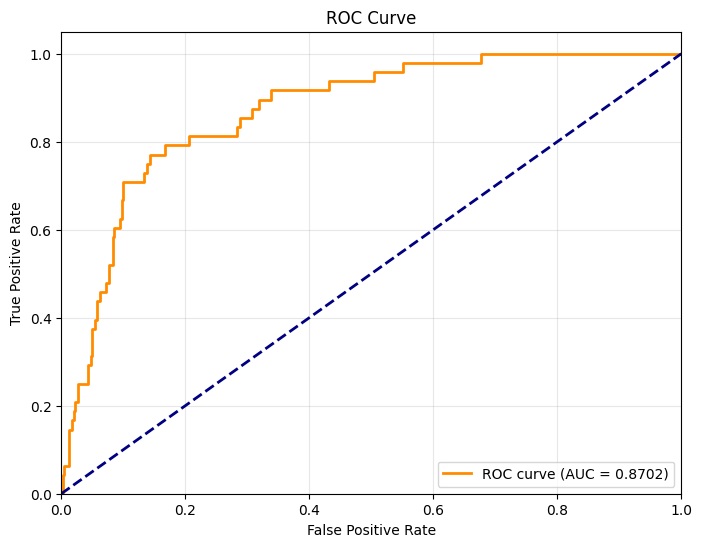

In [45]:
import os
import time
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torchaudio
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio.transforms import MelSpectrogram
from torchvggish import vggish, vggish_input

from sklearn.metrics import classification_report, confusion_matrix

from pathlib import Path
from dataclasses import dataclass

from transformers import WhisperProcessor, WhisperModel

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# ------------------ Config ------------------
SAMPLE_RATE = 16000
SEGMENT_LENGTH = 10 * SAMPLE_RATE
mel_kwargs = {
    "n_fft": 1024,
    "hop_length": 512,
    "n_mels": 64,
}
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)
BREATHING_LABELS = {"breathing", "clean breathing", "heavy breathing"}

# ------------------ New Training Params ------------------
@dataclass
class TrainingParams:
    num_epochs: int = 1000
    batch_size: int = 64
    learning_rate: float = 1e-4
    weight_decay: float = 1e-5
    patience: int = 100
    eval_every: int = 10
    train_csv_path: str = "train_log.csv"
    val_csv_path: str = "val_log.csv"

# ------------------ Utils ------------------
def load_labels(label_path):
    labels = []
    with open(label_path, "r") as f:
        for line in f:
            onset, offset, label = line.strip().split(maxsplit=2)
            labels.append((float(onset), float(offset), label.lower().strip()))
    return labels

def is_breathing_segment(start, end, label_entries):
    for onset, offset, label in label_entries:
        if label in BREATHING_LABELS or "breathing" in label:
            # If overlap exists between the segment and the label time
            if max(onset, start) < min(offset, end):
                return 1
    return 0

# ------------------ Dataset ------------------
class BreathingSegmentDataset(Dataset):
    def __init__(self, audio_dir, label_dir, segment_length=SEGMENT_LENGTH, transform=None):
        self.data = []
        self.transform = transform
        audio_files = glob.glob(f"{audio_dir}/**/*.wav", recursive=True)
        for audio_path in audio_files:
            file_id = Path(audio_path).stem
            label_path = os.path.join(label_dir, f"{file_id}.txt")
            if not os.path.exists(label_path):
                print(f"Label file not found for {audio_path}, skipping...")
                continue
            labels = load_labels(label_path)
            waveform, sr = torchaudio.load(audio_path)
            if sr != SAMPLE_RATE:
                waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)

            for start in range(0, waveform.shape[1] - segment_length, segment_length):
                segment = waveform[:, start:start+segment_length]
                label = is_breathing_segment(start/SAMPLE_RATE, (start+segment_length)/SAMPLE_RATE, labels)
                self.data.append((segment, label))

    def __len__(self):
        return len(self.data)

    # def __getitem__(self, idx):
    #     waveform, label = self.data[idx]
    #     if self.transform:
    #         features = self.transform(waveform)
    #     else:
    #         features = waveform
    #     return features.squeeze(0), label
    
    def __getitem__(self, idx):
        waveform, label = self.data[idx]
        return waveform, label  # keep raw waveform


# ------------------ Encoder ------------------
class VGGishEncoder(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        self.vggish = vggish(postprocess=False)
        self.vggish.eval()  # freeze pretrained layers
        self.proj = nn.Linear(128, out_dim)  # VGGish outputs 128-dim features

    def forward(self, x):
        # x shape: [B, 1, T], where T is audio length
        embeddings = []
        for i in range(x.size(0)):
            waveform = x[i].squeeze().cpu().numpy()  # [T]
            examples = vggish_input.waveform_to_examples(waveform, SAMPLE_RATE)  # [N, 96, 64]

            examples = examples.float().to(x.device)  # [N, 1, 96, 64]
            with torch.no_grad():
                feat = self.vggish(examples)  # [N, 128]
            embeddings.append(feat.mean(dim=0))  # average over time windows

        embeddings = torch.stack(embeddings).to(x.device)  # [B, 128]
        return self.proj(embeddings)  # [B, out_dim]

class WhisperEncoder(nn.Module):
    def __init__(self, model_name="openai/whisper-small", out_dim=64):
        super().__init__()
        self.processor = WhisperProcessor.from_pretrained(model_name)
        self.model = WhisperModel.from_pretrained(model_name)
        self.model.eval()  # Freeze the encoder
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Projection layer to match desired output dim
        self.proj = nn.Linear(self.model.config.d_model, out_dim)

    def forward(self, x):
        # x: [B, 1, T] in waveform format
        embeddings = []
        for i in range(x.size(0)):
            waveform = x[i].squeeze().cpu()
            input_features = self.processor.feature_extractor(
                waveform.numpy(), sampling_rate=SAMPLE_RATE, return_tensors="pt"
            ).input_features  # shape: [1, 80, 3000]

            with torch.no_grad():
                encoder_outputs = self.model.encoder(input_features.to(x.device))
                # Mean-pooling across time dimension
                emb = encoder_outputs.last_hidden_state.mean(dim=1)  # [1, hidden_dim]
                embeddings.append(emb.squeeze(0))

        embeddings = torch.stack(embeddings)  # [B, hidden_dim]
        return self.proj(embeddings)  # [B, out_dim]


# ------------------ Modified Encoder ------------------
class VGGishClassifier(nn.Module):
    def __init__(self, out_dim=64, num_classes=2):
        super().__init__()
        self.encoder = VGGishEncoder(out_dim)
        self.classifier = nn.Linear(out_dim, num_classes)
        
    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

# ------------------ New Training Loop ------------------
def train_model(train_loader, val_loader, model, params: TrainingParams):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), 
                               lr=params.learning_rate,
                               weight_decay=params.weight_decay)
    
    best_loss = float('inf')  # Initialize to infinity for minimization
    no_improve = 0

    # Lists to collect metrics
    train_metrics = []
    val_metrics = []
    
    for epoch in range(params.num_epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = total_loss / total
        train_acc = 100 * correct / total
        
        train_metrics.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_acc': train_acc})

        # Only evaluate every n epochs
        if (epoch + 1) % params.eval_every == 0 or epoch == params.num_epochs - 1:
            model.eval()
            total_loss = 0.0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for inputs, labels in tqdm(val_loader, desc=f"Evaluation"):
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    total_loss += loss.item() * labels.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            val_acc = 100 * correct / total
            val_loss = total_loss / total
            print(f"Epoch {epoch+1}/{params.num_epochs}")
            print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")
            
            # Append metrics for this epoch
            val_metrics.append({'epoch': epoch+1, 'val_loss': val_loss, 'val_acc': val_acc})    

            if val_loss < best_loss:
                best_loss = val_loss
                no_improve = 0
                print(f"New best model found at epoch {epoch+1} with val acc: {val_acc:.2f}% and loss: {val_loss:.4f}")
                torch.save(model.state_dict(), "best_model.pt")
            else:
                no_improve += 1
                
            if no_improve >= params.patience:
                print("Early stopping")
                break

    # Save metrics to CSV using pandas
    pd.DataFrame(train_metrics).to_csv(params.train_csv_path, index=False)
    pd.DataFrame(val_metrics).to_csv(params.val_csv_path, index=False)

# ------------------ Modified Evaluation ------------------
def evaluate_model(loader, model, criterion, log_path="test_eval_log.csv", cm_path="test_confusion_matrix.csv"):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=f"Evaluation Progress"):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    acc = 100 * correct / total
    avg_loss = total_loss / total

    # === Metrics ===
    print(f"\nFinal Evaluation on Test Set:")
    print(f"Accuracy: {acc:.2f}%, Loss: {avg_loss:.4f}")

    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, output_dict=True)
    verbose_report = classification_report(all_labels, all_preds)
    print(verbose_report)

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    log_data = {
        "test_accuracy": [acc],
        "test_loss": [avg_loss],
    }
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                log_data[f"{label}_{metric}"] = [value]
    pd.DataFrame(log_data).to_csv(log_path, index=False)
    print(f"Test evaluation log saved to {log_path}")

    # === Save Confusion Matrix ===
    cm_df = pd.DataFrame(cm)
    cm_df.to_csv(cm_path, index=False)
    print(f"Confusion matrix saved to {cm_path}")

    # === Save Classification Report ===
    results_path = "result.txt"
    with open(results_path, "w") as f:
        f.write(f"Final Evaluation on Test Set:\n")
        f.write(f"Accuracy: {acc:.2f}%, Loss: {avg_loss:.4f}\n\n")
        f.write("=== Classification Report ===\n")
        f.write(str(verbose_report))
    print(f"Classification report saved to {results_path}")

def plot_roc_curve_standalone(model_path, test_loader):
    """
    Load a saved model and plot ROC curve
    """
    # Load the saved model
    model = VGGishClassifier(out_dim=64, num_classes=2).to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Generating ROC data"):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            pos_probs = probs[:, 1]  # Probability of positive class
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(pos_probs.cpu().numpy())
    
    # Calculate and plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return roc_auc



# ------------------ Updated Main Execution ------------------
if __name__ == "__main__":
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)
    # Dataset and DataLoader setup
    transform = MelSpectrogram(sample_rate=SAMPLE_RATE, **mel_kwargs)
    dataset = BreathingSegmentDataset("audio", "clean_label", transform=transform)
    
    # Split dataset
    train_len = int(0.7 * len(dataset))
    val_len = int(0.15 * len(dataset))
    test_len = len(dataset) - train_len - val_len
    
    train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])
   
    print(f"Dataset size: {len(dataset)} samples")
    print(f"Training set size: {len(train_set)} samples")
    print(f"Validation set size: {len(val_set)} samples")
    print(f"Test set size: {len(test_set)} samples")
    
    # Create DataLoaders
    params = TrainingParams()
    train_loader = DataLoader(train_set, batch_size=params.batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=params.batch_size)
    test_loader = DataLoader(test_set, batch_size=params.batch_size)

    auc_score = plot_roc_curve_standalone("./exp/20250520/2/best_model.pt", test_loader)
    



In [30]:
import os
import time
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torchaudio
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio.transforms import MelSpectrogram
from torchvggish import vggish, vggish_input

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from pathlib import Path
from dataclasses import dataclass

from transformers import WhisperProcessor, WhisperModel

# ------------------ Config ------------------
SAMPLE_RATE = 16000
SEGMENT_LENGTH = 10 * SAMPLE_RATE
mel_kwargs = {
    "n_fft": 1024,
    "hop_length": 512,
    "n_mels": 64,
}
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)
BREATHING_LABELS = {
    "breathing": 0,           # Normal breathing
    "light breathing": 1,     # Light breathing
    "heavy breathing": 2,     # Heavy breathing
    "heavy breathing with noises": 3,  # Heavy breathing with noises
    "no breathing": 4         # No breathing
}

@dataclass
class TrainingParams:
    n_episodes: int = 10000
    n_way: int = 5
    k_shot: int = 10
    q_query: int = 15
    learning_rate: float = 1e-4
    eval_every: int = 10
    scheduler_step: int = 2000       
    scheduler_gamma: float = 0.5
    patience: int = 500
    save_train_log: str = "training_log.csv"
    save_eval_log: str = "eval_log.csv"
    best_model_path = "./exp/20250524/1/best_model.pt"


# ------------------ Utils ------------------
def load_labels(label_path):
    labels = []
    with open(label_path, "r") as f:
        for line in f:
            onset, offset, label = line.strip().split(maxsplit=2)
            labels.append((float(onset), float(offset), label.lower().strip()))
    return labels

def is_breathing_segment(start, end, label_entries):
    for onset, offset, label in label_entries:
        label = label.lower().strip()
        # If overlap exists between the segment and the label time
        if max(onset, start) < min(offset, end):
            # Find the most specific (longest) matching breathing type
            best_match = None
            best_match_length = 0
            best_class_idx = None
            
            for breathing_type, class_idx in BREATHING_LABELS.items():
                if breathing_type in label and len(breathing_type) > best_match_length:
                    best_match = breathing_type
                    best_match_length = len(breathing_type)
                    best_class_idx = class_idx
            
            if best_match is not None:
                return best_class_idx
    
    return 4  # Default to "no breathing" if no overlap found


# ------------------ Dataset ------------------
class BreathingSegmentDataset(Dataset):
    def __init__(self, audio_dir, label_dir, segment_length=SEGMENT_LENGTH, transform=None):
        self.data = []
        self.transform = transform
        audio_files = glob.glob(f"{audio_dir}/**/*.wav", recursive=True)
        for audio_path in audio_files:
            file_id = Path(audio_path).stem
            label_path = os.path.join(label_dir, f"{file_id}.txt")
            if not os.path.exists(label_path):
                print(f"Label file not found for {audio_path}, skipping...")
                continue
            labels = load_labels(label_path)
            waveform, sr = torchaudio.load(audio_path)
            if sr != SAMPLE_RATE:
                waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)

            for start in range(0, waveform.shape[1] - segment_length, segment_length):
                segment = waveform[:, start:start+segment_length]
                label = is_breathing_segment(start/SAMPLE_RATE, (start+segment_length)/SAMPLE_RATE, labels)
                self.data.append((segment, label))

    def __len__(self):
        return len(self.data)

    # def __getitem__(self, idx):
    #     waveform, label = self.data[idx]
    #     if self.transform:
    #         features = self.transform(waveform)
    #     else:
    #         features = waveform
    #     return features.squeeze(0), label
    
    def __getitem__(self, idx):
        waveform, label = self.data[idx]
        return waveform, label  # keep raw waveform


# ------------------ Encoder ------------------
class CNNEncoder(nn.Module):
    def __init__(self, out_dim=64, sample_rate=SAMPLE_RATE, segment_length=SEGMENT_LENGTH, mel_kwargs=None):
        super().__init__()
        self.mel_transform = MelSpectrogram(
            sample_rate=sample_rate,
            **mel_kwargs,
        )
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )

        # Dynamically compute flattened size using the same spectrogram transform
        with torch.no_grad():
            dummy_waveform = torch.zeros(1, segment_length)
            mel_spec = self.mel_transform(dummy_waveform)  # [1, n_mels, time]
            mel_spec = mel_spec.unsqueeze(0)  # Add batch and channel dims: [1, 1, n_mels, time]
            conv_out = self.conv_layers(mel_spec)
            self.flatten_dim = conv_out.view(1, -1).shape[1]

        self.fc = nn.Linear(self.flatten_dim, out_dim)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class VGGishEncoder(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        self.vggish = vggish(postprocess=False)
        self.vggish.eval()  # freeze pretrained layers
        self.proj = nn.Linear(128, out_dim)  # VGGish outputs 128-dim features

    def forward(self, x):
        # x shape: [B, 1, T], where T is audio length
        embeddings = []
        for i in range(x.size(0)):
            waveform = x[i].squeeze().cpu().numpy()  # [T]
            examples = vggish_input.waveform_to_examples(waveform, SAMPLE_RATE)  # [N, 96, 64]

            examples = examples.float().to(x.device)  # [N, 1, 96, 64]
            with torch.no_grad():
                feat = self.vggish(examples)  # [N, 128]
            embeddings.append(feat.mean(dim=0))  # average over time windows

        embeddings = torch.stack(embeddings).to(x.device)  # [B, 128]
        return self.proj(embeddings)  # [B, out_dim]

class WhisperEncoder(nn.Module):
    def __init__(self, model_name="openai/whisper-small", out_dim=64):
        super().__init__()
        self.processor = WhisperProcessor.from_pretrained(model_name)
        self.model = WhisperModel.from_pretrained(model_name)
        self.model.eval()  # Freeze the encoder
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Projection layer to match desired output dim
        self.proj = nn.Linear(self.model.config.d_model, out_dim)

    def forward(self, x):
        # x: [B, 1, T] in waveform format
        embeddings = []
        for i in range(x.size(0)):
            waveform = x[i].squeeze().cpu()
            input_features = self.processor.feature_extractor(
                waveform.numpy(), sampling_rate=SAMPLE_RATE, return_tensors="pt"
            ).input_features  # shape: [1, 80, 3000]

            with torch.no_grad():
                encoder_outputs = self.model.encoder(input_features.to(x.device))
                # Mean-pooling across time dimension
                emb = encoder_outputs.last_hidden_state.mean(dim=1)  # [1, hidden_dim]
                embeddings.append(emb.squeeze(0))

        embeddings = torch.stack(embeddings)  # [B, hidden_dim]
        return self.proj(embeddings)  # [B, out_dim]



# ------------------ Prototypical Network ------------------
def compute_prototypes(support, support_labels):
    classes = torch.unique(support_labels)
    prototypes = []
    for cls in classes:
        cls_embeddings = support[support_labels == cls]
        prototypes.append(cls_embeddings.mean(dim=0))
    return torch.stack(prototypes), classes

def prototypical_loss(encoder, support, support_labels, query, query_labels):
    support_embeddings = encoder(support)
    query_embeddings = encoder(query)

    prototypes, proto_labels = compute_prototypes(support_embeddings, support_labels)

    dists = torch.cdist(query_embeddings, prototypes)
    log_p_y = F.log_softmax(-dists, dim=1)
    target_inds = torch.tensor([torch.where(proto_labels == y)[0].item() for y in query_labels])
    loss = F.nll_loss(log_p_y, target_inds.to(DEVICE))
    acc = (log_p_y.argmax(dim=1) == target_inds.to(DEVICE)).float().mean()
    return loss, acc

# ------------------ Episode Generator ------------------
def create_episode(dataset, n_way=5, k_shot=5, q_query=5):
    # Get available classes in the dataset
    available_classes = set([x[1] for x in dataset])
    # Ensure we don't try to sample more classes than available
    n_way = min(n_way, len(available_classes))
    classes = random.sample(list(available_classes), n_way)
    
    support, query = [], []
    for cls in classes:
        items = [x for x in dataset if x[1] == cls]
        if len(items) < k_shot + q_query:
            # If not enough samples, sample with replacement
            chosen = random.choices(items, k=k_shot + q_query)
        else:
            chosen = random.sample(items, k_shot + q_query)
        support.extend(chosen[:k_shot])
        query.extend(chosen[k_shot:])
    
    support_x = torch.stack([x[0] for x in support]).unsqueeze(1).to(DEVICE)
    support_y = torch.tensor([x[1] for x in support]).to(DEVICE)
    query_x = torch.stack([x[0] for x in query]).unsqueeze(1).to(DEVICE)
    query_y = torch.tensor([x[1] for x in query]).to(DEVICE)
    return support_x, support_y, query_x, query_y

# ------------------ Training Loop ------------------
def train_protonet(dataset, encoder, params: TrainingParams):
    optimizer = torch.optim.Adam(encoder.parameters(), lr=params.learning_rate)
    encoder.train()

    history = {"episode": [], "loss": [], "accuracy": []}

    for episode in range(params.n_episodes):
        support_x, support_y, query_x, query_y = create_episode(
            dataset, n_way=params.n_way, k_shot=params.k_shot, q_query=params.q_query
        )
        loss, acc = prototypical_loss(encoder, support_x, support_y, query_x, query_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        history["episode"].append(episode)
        history["loss"].append(loss.item())
        history["accuracy"].append(acc.item())

        if episode % 50 == 0:
            print(f"[Train] Episode {episode}: Loss={loss.item():.4f}, Acc={acc.item():.4f}")

    pd.DataFrame(history).to_csv(params.save_train_log, index=False)
    print(f"Training log saved to {params.save_train_log}")

def train_protonet_with_eval(train_set, val_set, encoder, params: TrainingParams):
    start_time = time.time()

    optimizer = torch.optim.Adam(encoder.parameters(), lr=params.learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=params.n_episodes, eta_min=1e-6
    )
    encoder.train()

    train_history = {"episode": [], "loss": [], "accuracy": [], "lr": []}
    eval_history = {"episode": [], "loss": [], "accuracy": []}

    best_val_acc = 0.0
    best_val_loss = float('inf')  # Start with infinity
    no_improve_counter = 0

    for episode in range(params.n_episodes):
        # Training
        support_x, support_y, query_x, query_y = create_episode(
            train_set, n_way=params.n_way, k_shot=params.k_shot, q_query=params.q_query
        )
        loss, acc = prototypical_loss(encoder, support_x, support_y, query_x, query_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        current_lr = scheduler.get_last_lr()[0]
        train_history["episode"].append(episode)
        train_history["loss"].append(loss.item())
        train_history["accuracy"].append(acc.item())
        train_history["lr"].append(current_lr)

        print(f"[Train] Episode {episode}: Loss={loss.item():.4f}, Acc={acc.item():.4f}, LR={current_lr:.6f}")

        # Evaluation
        if (episode + 1) % params.eval_every == 0:
            encoder.eval()
            with torch.no_grad():
                support_x, support_y, query_x, query_y = create_episode(
                    val_set, n_way=params.n_way, k_shot=params.k_shot, q_query=params.q_query
                )
                val_loss, val_acc = prototypical_loss(encoder, support_x, support_y, query_x, query_y)
                eval_history["episode"].append(episode)
                eval_history["loss"].append(val_loss.item())
                eval_history["accuracy"].append(val_acc.item())
                print(f"[Eval]  Episode {episode}: Val Loss={val_loss.item():.4f}, Val Acc={val_acc.item():.4f}")

                if val_acc.item() > best_val_acc:
                    best_val_acc = val_acc.item()

                if val_loss.item() < best_val_loss:
                    best_val_loss = val_loss.item()
                    no_improve_counter = 0
                    torch.save(encoder.state_dict(), params.best_model_path)
                    print(f"Saved new best model at episode {episode} with val loss {best_val_loss:.4f}")
                else:
                    no_improve_counter += 1
                    print(f"No improvement. Counter: {no_improve_counter}/{params.patience}")

                # Early stopping check
                if no_improve_counter >= params.patience:
                    print(f"Early stopping at episode {episode} (val loss stopped improving)")
                    break

            encoder.train()

    # Save logs
    pd.DataFrame(train_history).to_csv(params.save_train_log, index=False)
    pd.DataFrame(eval_history).to_csv(params.save_eval_log, index=False)
    elapsed_time = time.time() - start_time
    print(f"\nTraining completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    print(f"Best model saved to {params.best_model_path} with val acc {best_val_acc:.4f}, val loss {best_val_loss:.4f}")
    with open('train_log.txt', 'w') as f:
        f.write(f"Total training time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)\n")
        f.write(f"Best validation accuracy: {best_val_acc:.4f}\n")
        f.write(f"Best validation loss: {best_val_loss:.4f}\n")

# ------------------ Evaluate ------------------
def evaluate_model(encoder, dataset, params, n_episodes=100, 
                   log_path="test_eval_log.csv", cm_path="test_confusion_matrix.csv"):
    encoder.eval()
    accs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for _ in tqdm(range(n_episodes), desc="Evaluating"):
            support_x, support_y, query_x, query_y = create_episode(
                dataset,
                n_way=params.n_way,
                k_shot=params.k_shot,
                q_query=params.q_query
            )

            support_emb = encoder(support_x)
            query_emb = encoder(query_x)

            prototypes, proto_labels = compute_prototypes(support_emb, support_y)
            dists = torch.cdist(query_emb, prototypes)
            log_p_y = F.log_softmax(-dists, dim=1)
            preds = log_p_y.argmax(dim=1)
            pred_labels = proto_labels[preds]

            acc = (pred_labels == query_y).float().mean().item()
            accs.append(acc)

            all_preds.extend(pred_labels.cpu().numpy())
            all_labels.extend(query_y.cpu().numpy())

    # === Metrics ===
    mean_acc = np.mean(accs)
    std_acc = np.std(accs)
    print(f"\nFinal Evaluation on Test Set ({n_episodes} episodes):")
    print(f"Mean Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")

    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, output_dict=True)
    verbose_report = classification_report(all_labels, all_preds)
    print(verbose_report)

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # === Save Summary Log ===
    log_data = {
        "mean_accuracy": [mean_acc],
        "std_accuracy": [std_acc],
        "n_episodes": [n_episodes]
    }
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                log_data[f"{label}_{metric}"] = [value]

    pd.DataFrame(log_data).to_csv(log_path, index=False)
    print(f"Test evaluation log saved to {log_path}")

    # === Save Confusion Matrix ===
    cm_df = pd.DataFrame(cm)
    cm_df.to_csv(cm_path, index=False)
    print(f"Confusion matrix saved to {cm_path}")

    # === Save Classification Report ===
    results_path = "result.txt"
    with open(results_path, "w") as f:
        f.write("=== Classification Report ===\n")
        f.write(f"Mean Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%\n\n")
        f.write(str(verbose_report))
    print(f"Classification report saved to {results_path}")

def evaluate_with_full_prototypes(encoder, train_val_dataset, test_dataset, device):
    encoder.eval()
    
    # Aggregate all embeddings and labels from train+val
    embeddings = []
    labels = []
    with torch.no_grad():
        for x, y in train_val_dataset:
            x = x.unsqueeze(0).unsqueeze(0).to(device)  # Add batch and channel dims
            emb = encoder(x)
            embeddings.append(emb.cpu())
            labels.append(y)
    embeddings = torch.cat(embeddings)
    labels = torch.tensor(labels)
    
    # Compute prototypes by averaging embeddings per class
    classes = torch.unique(labels)
    prototypes = []
    for c in classes:
        class_embs = embeddings[labels == c]
        prototype = class_embs.mean(dim=0)
        prototypes.append(prototype)
    prototypes = torch.stack(prototypes).to(device)
    
    # Evaluate on test set
    test_embeddings = []
    test_labels = []
    with torch.no_grad():
        for x, y in tqdm(test_dataset, desc="Testing"):
            x = x.unsqueeze(0).unsqueeze(0).to(device)
            emb = encoder(x)
            test_embeddings.append(emb.cpu())
            test_labels.append(y)
    test_embeddings = torch.cat(test_embeddings)
    test_labels = torch.tensor(test_labels)
    
    # Compute distances to prototypes and predict
    dists = torch.cdist(test_embeddings, prototypes.cpu())
    preds = dists.argmin(dim=1)
    
    # Calculate accuracy and classification report
    acc = accuracy_score(test_labels, preds)
    report = classification_report(test_labels, preds, zero_division=0, output_dict=True)
    conf_matrix = confusion_matrix(test_labels, preds)
    
    # Fix: Properly handle the classification report dictionary
    # Create DataFrame from the nested dictionary structure
    report_data = []
    for class_label, metrics in report.items():
        if isinstance(metrics, dict):  # Skip non-dict entries like 'accuracy'
            row = {'class': class_label}
            row.update(metrics)
            report_data.append(row)
    
    report_df = pd.DataFrame(report_data)
    report_df.to_csv('full_proto_classification_report.csv', index=False)
    
    # Save confusion matrix to CSV using pandas
    conf_matrix_df = pd.DataFrame(conf_matrix, index=classes.numpy(), columns=classes.numpy())
    conf_matrix_df.to_csv('full_proto_confusion_matrix.csv')
    
    # Save summary to result.txt
    with open('full_proto_result.txt', 'w') as f:
        f.write(f"Test Accuracy: {acc:.4f}\n\n")
        f.write("Classification Report:\n")
        for key, value in report.items():
            if isinstance(value, dict):  # Only process class-specific metrics
                f.write(f"Class {key}: Precision={value['precision']:.4f}, Recall={value['recall']:.4f}, F1-Score={value['f1-score']:.4f}, Support={value['support']}\n")
        f.write(f"\nOverall Accuracy: {report['accuracy']:.4f}\n")
        f.write("\nConfusion Matrix:\n")
        f.write(str(conf_matrix))

    return acc, report, conf_matrix


# ------------------ Run ------------------
if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)

    transform = MelSpectrogram(sample_rate=SAMPLE_RATE, **mel_kwargs)
    dataset = BreathingSegmentDataset("audio", "strong_labels", transform=transform)
    # encoder = CNNEncoder(mel_kwargs=mel_kwargs).to(DEVICE)
    encoder = VGGishEncoder(out_dim=128).to(DEVICE)


    total_len = len(dataset)
    train_len = int(0.7 * total_len)
    val_len = int(0.15 * total_len)
    test_len = total_len - train_len - val_len

    train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

    print(f"Dataset size: {len(dataset)} samples")
    print(f"Training set size: {len(train_set)} samples")
    print(f"Validation set size: {len(val_set)} samples")
    print(f"Test set size: {len(test_set)} samples")

    # Print class distribution
    class_counts = {}
    for _, label in dataset:
        class_counts[label] = class_counts.get(label, 0) + 1
    
    print("Class distribution:")
    for class_idx, count in class_counts.items():
        class_name = [k for k, v in BREATHING_LABELS.items() if v == class_idx][0]
        print(f"  {class_name}: {count} samples")

    params = TrainingParams(
        # n_episodes=10000,
        # eval_every=20,
        # save_train_log="training_log.csv",
        # save_eval_log="eval_log.csv"
    )

    # Load best model
    encoder.load_state_dict(torch.load(params.best_model_path, weights_only=True))
    encoder.to(DEVICE)
    encoder.eval()

    # Evaluate
    # evaluate_model(
    #     encoder,
    #     test_set,
    #     params,
    #     n_episodes=1000,
    #     log_path="test_eval_log.csv",
    #     cm_path="test_confusion_matrix.csv"
    # )

    train_val_dataset = torch.utils.data.ConcatDataset([train_set, val_set])
    # Evaluate with full prototypes and save results
    accuracy, report, conf_matrix = evaluate_with_full_prototypes(
        encoder, train_val_dataset, test_set, DEVICE
    )

    print(f"Final Test Accuracy: {accuracy:.4f}")
    print(f"Classification report: {str(report)}.")
    print(f"Confusion matrix: {str(conf_matrix)}.")


Using device: cuda
Label file not found for audio/Normal/20241130_10B.wav, skipping...
Label file not found for audio/Normal/20241130_11R.wav, skipping...
Label file not found for audio/Normal/20241014_228.wav, skipping...
Label file not found for audio/Normal/20241008_229.wav, skipping...
Label file not found for audio/Normal/20241008_226.wav, skipping...
Label file not found for audio/Normal/20241130_14.wav, skipping...
Label file not found for audio/Normal/20241008_209.wav, skipping...
Label file not found for audio/Normal/20250109_503.wav, skipping...
Label file not found for audio/Abnormal/20241008_223.wav, skipping...
Label file not found for audio/Abnormal/20250121_86.wav, skipping...
Label file not found for audio/Abnormal/20250121_497.wav, skipping...
Label file not found for audio/Abnormal/20241005_219.wav, skipping...
Label file not found for audio/Abnormal/20250114_14.wav, skipping...
Label file not found for audio/Abnormal/20250121_517.wav, skipping...
Label file not found

Testing: 100%|██████████| 562/562 [00:34<00:00, 16.34it/s]

Final Test Accuracy: 0.5587
Classification report: {'0': {'precision': 0.041666666666666664, 'recall': 0.3333333333333333, 'f1-score': 0.07407407407407407, 'support': 6.0}, '1': {'precision': 0.07692307692307693, 'recall': 0.6, 'f1-score': 0.13636363636363635, 'support': 5.0}, '2': {'precision': 0.13043478260869565, 'recall': 0.42857142857142855, 'f1-score': 0.2, 'support': 21.0}, '3': {'precision': 0.09433962264150944, 'recall': 0.37037037037037035, 'f1-score': 0.15037593984962405, 'support': 27.0}, '4': {'precision': 0.9666666666666667, 'recall': 0.5765407554671969, 'f1-score': 0.7222914072229141, 'support': 503.0}, 'accuracy': 0.5587188612099644, 'macro avg': {'precision': 0.2620061631013231, 'recall': 0.4617631775484658, 'f1-score': 0.2566210115020497, 'support': 562.0}, 'weighted avg': {'precision': 0.8757193042064984, 'recall': 0.5587188612099644, 'f1-score': 0.6631654641198012, 'support': 562.0}}.
Confusion matrix: [[  2   0   2   0   2]
 [  1   3   0   1   0]
 [  6   1   9   4 

Using device: cuda
Label file not found for audio/Normal/20241130_10B.wav, skipping...
Label file not found for audio/Normal/20241130_11R.wav, skipping...
Label file not found for audio/Normal/20241014_228.wav, skipping...
Label file not found for audio/Normal/20241008_229.wav, skipping...
Label file not found for audio/Normal/20241008_226.wav, skipping...
Label file not found for audio/Normal/20241130_14.wav, skipping...
Label file not found for audio/Normal/20241008_209.wav, skipping...
Label file not found for audio/Normal/20250109_503.wav, skipping...
Label file not found for audio/Abnormal/20241008_223.wav, skipping...
Label file not found for audio/Abnormal/20250121_86.wav, skipping...
Label file not found for audio/Abnormal/20250121_497.wav, skipping...
Label file not found for audio/Abnormal/20241005_219.wav, skipping...
Label file not found for audio/Abnormal/20250114_14.wav, skipping...
Label file not found for audio/Abnormal/20250121_517.wav, skipping...
Label file not found

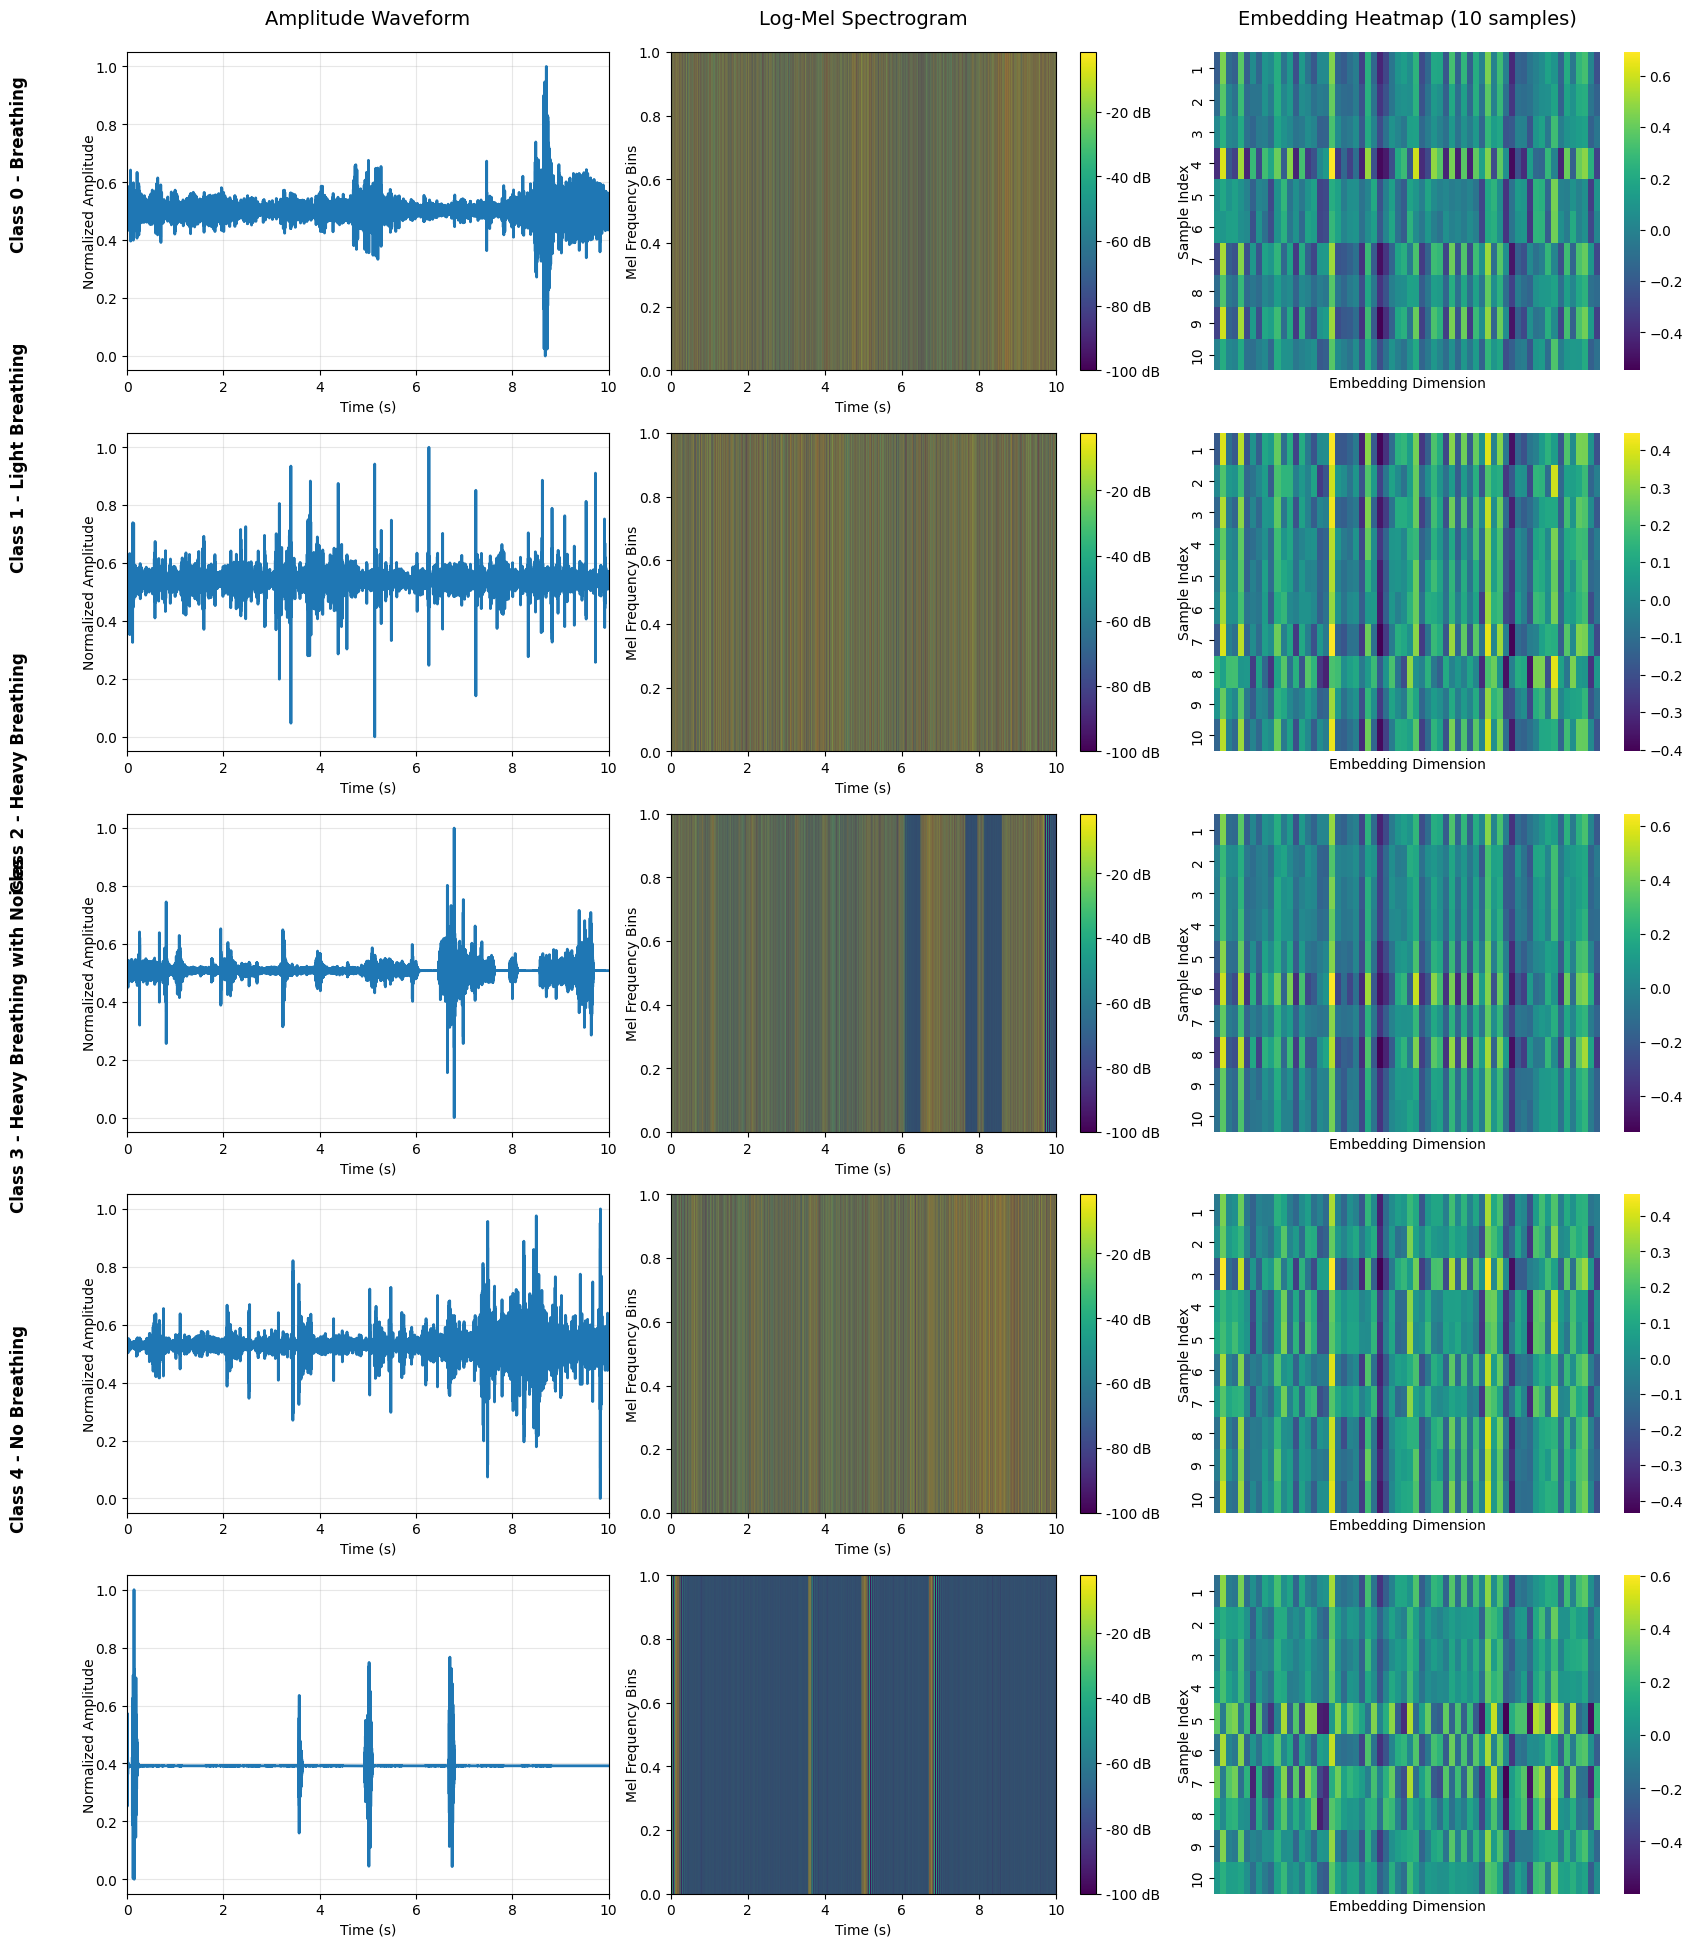

In [9]:
import os
import time
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import librosa

import torch
import torchaudio
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio.transforms import MelSpectrogram
from torchvggish import vggish, vggish_input

from sklearn.metrics import classification_report, confusion_matrix

from pathlib import Path
from dataclasses import dataclass

from transformers import WhisperProcessor, WhisperModel

import matplotlib.pyplot as plt
import seaborn as sns

# ------------------ Config ------------------
SAMPLE_RATE = 16000
SEGMENT_LENGTH = 10 * SAMPLE_RATE
mel_kwargs = {
    "n_fft": 1024,
    "hop_length": 512,
    "n_mels": 64,
}
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)
# BREATHING_LABELS = {"breathing", "clean breathing", "heavy breathing"}
BREATHING_LABELS = {
    "breathing": 0,           # Normal breathing
    "light breathing": 1,     # Light breathing
    "heavy breathing": 2,     # Heavy breathing
    "heavy breathing with noises": 3,  # Heavy breathing with noises
    "no breathing": 4         # No breathing
}

@dataclass
class TrainingParams:
    n_episodes: int = 10000
    n_way: int = 2
    k_shot: int = 10
    q_query: int = 15
    learning_rate: float = 1e-4
    eval_every: int = 10
    scheduler_step: int = 2000       
    scheduler_gamma: float = 0.5
    patience: int = 10
    save_train_log: str = "training_log.csv"
    save_eval_log: str = "eval_log.csv"
    best_model_path = "best_model.pt"


# ------------------ Utils ------------------
def load_labels(label_path):
    labels = []
    with open(label_path, "r") as f:
        for line in f:
            onset, offset, label = line.strip().split(maxsplit=2)
            labels.append((float(onset), float(offset), label.lower().strip()))
    return labels

# def is_breathing_segment(start, end, label_entries):
#     for onset, offset, label in label_entries:
#         if label in BREATHING_LABELS or "breathing" in label:
#             # If overlap exists between the segment and the label time
#             if max(onset, start) < min(offset, end):
#                 return 1
#     return 0

def is_breathing_segment(start, end, label_entries):
    for onset, offset, label in label_entries:
        label = label.lower().strip()
        # If overlap exists between the segment and the label time
        if max(onset, start) < min(offset, end):
            # Find the most specific (longest) matching breathing type
            best_match = None
            best_match_length = 0
            best_class_idx = None
            
            for breathing_type, class_idx in BREATHING_LABELS.items():
                if breathing_type in label and len(breathing_type) > best_match_length:
                    best_match = breathing_type
                    best_match_length = len(breathing_type)
                    best_class_idx = class_idx
            
            if best_match is not None:
                return best_class_idx
    
    return 4  # Default to "no breathing" if no overlap found

# ------------------ Dataset ------------------
class BreathingSegmentDataset(Dataset):
    def __init__(self, audio_dir, label_dir, segment_length=SEGMENT_LENGTH, transform=None):
        self.data = []
        self.transform = transform
        audio_files = glob.glob(f"{audio_dir}/**/*.wav", recursive=True)
        for audio_path in audio_files:
            file_id = Path(audio_path).stem
            label_path = os.path.join(label_dir, f"{file_id}.txt")
            if not os.path.exists(label_path):
                print(f"Label file not found for {audio_path}, skipping...")
                continue
            labels = load_labels(label_path)
            waveform, sr = torchaudio.load(audio_path)
            if sr != SAMPLE_RATE:
                waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)

            for start in range(0, waveform.shape[1] - segment_length, segment_length):
                segment = waveform[:, start:start+segment_length]
                label = is_breathing_segment(start/SAMPLE_RATE, (start+segment_length)/SAMPLE_RATE, labels)
                self.data.append((segment, label))

    def __len__(self):
        return len(self.data)

    # def __getitem__(self, idx):
    #     waveform, label = self.data[idx]
    #     if self.transform:
    #         features = self.transform(waveform)
    #     else:
    #         features = waveform
    #     return features.squeeze(0), label
    
    def __getitem__(self, idx):
        waveform, label = self.data[idx]
        return waveform, label  # keep raw waveform


# ------------------ Encoder ------------------
class CNNEncoder(nn.Module):
    def __init__(self, out_dim=64, sample_rate=SAMPLE_RATE, segment_length=SEGMENT_LENGTH, mel_kwargs=None):
        super().__init__()
        self.mel_transform = MelSpectrogram(
            sample_rate=sample_rate,
            **mel_kwargs,
        )
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )

        # Dynamically compute flattened size using the same spectrogram transform
        with torch.no_grad():
            dummy_waveform = torch.zeros(1, segment_length)
            mel_spec = self.mel_transform(dummy_waveform)  # [1, n_mels, time]
            mel_spec = mel_spec.unsqueeze(0)  # Add batch and channel dims: [1, 1, n_mels, time]
            conv_out = self.conv_layers(mel_spec)
            self.flatten_dim = conv_out.view(1, -1).shape[1]

        self.fc = nn.Linear(self.flatten_dim, out_dim)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class VGGishEncoder(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        self.vggish = vggish(postprocess=False)
        self.vggish.eval()  # freeze pretrained layers
        self.proj = nn.Linear(128, out_dim)  # VGGish outputs 128-dim features

    def forward(self, x):
        # x shape: [B, 1, T], where T is audio length
        embeddings = []
        for i in range(x.size(0)):
            waveform = x[i].squeeze().cpu().numpy()  # [T]
            examples = vggish_input.waveform_to_examples(waveform, SAMPLE_RATE)  # [N, 96, 64]

            examples = examples.float().to(x.device)  # [N, 1, 96, 64]
            with torch.no_grad():
                feat = self.vggish(examples)  # [N, 128]
            embeddings.append(feat.mean(dim=0))  # average over time windows

        embeddings = torch.stack(embeddings).to(x.device)  # [B, 128]
        return self.proj(embeddings)  # [B, out_dim]

class WhisperEncoder(nn.Module):
    def __init__(self, model_name="openai/whisper-small", out_dim=64):
        super().__init__()
        self.processor = WhisperProcessor.from_pretrained(model_name)
        self.model = WhisperModel.from_pretrained(model_name)
        self.model.eval()  # Freeze the encoder
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Projection layer to match desired output dim
        self.proj = nn.Linear(self.model.config.d_model, out_dim)

    def forward(self, x):
        # x: [B, 1, T] in waveform format
        embeddings = []
        for i in range(x.size(0)):
            waveform = x[i].squeeze().cpu()
            input_features = self.processor.feature_extractor(
                waveform.numpy(), sampling_rate=SAMPLE_RATE, return_tensors="pt"
            ).input_features  # shape: [1, 80, 3000]

            with torch.no_grad():
                encoder_outputs = self.model.encoder(input_features.to(x.device))
                # Mean-pooling across time dimension
                emb = encoder_outputs.last_hidden_state.mean(dim=1)  # [1, hidden_dim]
                embeddings.append(emb.squeeze(0))

        embeddings = torch.stack(embeddings)  # [B, hidden_dim]
        return self.proj(embeddings)  # [B, out_dim]



# ------------------ Prototypical Network ------------------
def compute_prototypes(support, support_labels):
    classes = torch.unique(support_labels)
    prototypes = []
    for cls in classes:
        cls_embeddings = support[support_labels == cls]
        prototypes.append(cls_embeddings.mean(dim=0))
    return torch.stack(prototypes), classes

def prototypical_loss(encoder, support, support_labels, query, query_labels):
    support_embeddings = encoder(support)
    query_embeddings = encoder(query)

    prototypes, proto_labels = compute_prototypes(support_embeddings, support_labels)

    dists = torch.cdist(query_embeddings, prototypes)
    log_p_y = F.log_softmax(-dists, dim=1)
    target_inds = torch.tensor([torch.where(proto_labels == y)[0].item() for y in query_labels])
    loss = F.nll_loss(log_p_y, target_inds.to(DEVICE))
    acc = (log_p_y.argmax(dim=1) == target_inds.to(DEVICE)).float().mean()
    return loss, acc

# ------------------ Episode Generator ------------------
def create_episode(dataset, n_way=2, k_shot=5, q_query=5):
    classes = random.sample([0, 1], n_way)
    support, query = [], []
    for cls in classes:
        items = [x for x in dataset if x[1] == cls]
        chosen = random.sample(items, k_shot + q_query)
        support.extend(chosen[:k_shot])
        query.extend(chosen[k_shot:])
    support_x = torch.stack([x[0] for x in support]).unsqueeze(1).to(DEVICE)
    support_y = torch.tensor([x[1] for x in support]).to(DEVICE)
    query_x = torch.stack([x[0] for x in query]).unsqueeze(1).to(DEVICE)
    query_y = torch.tensor([x[1] for x in query]).to(DEVICE)
    return support_x, support_y, query_x, query_y

# ------------------ Training Loop ------------------
def train_protonet(dataset, encoder, params: TrainingParams):
    optimizer = torch.optim.Adam(encoder.parameters(), lr=params.learning_rate)
    encoder.train()

    history = {"episode": [], "loss": [], "accuracy": []}

    for episode in range(params.n_episodes):
        support_x, support_y, query_x, query_y = create_episode(
            dataset, n_way=params.n_way, k_shot=params.k_shot, q_query=params.q_query
        )
        loss, acc = prototypical_loss(encoder, support_x, support_y, query_x, query_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        history["episode"].append(episode)
        history["loss"].append(loss.item())
        history["accuracy"].append(acc.item())

        if episode % 50 == 0:
            print(f"[Train] Episode {episode}: Loss={loss.item():.4f}, Acc={acc.item():.4f}")

    pd.DataFrame(history).to_csv(params.save_train_log, index=False)
    print(f"Training log saved to {params.save_train_log}")

def train_protonet_with_eval(train_set, val_set, encoder, params: TrainingParams):
    start_time = time.time()

    optimizer = torch.optim.Adam(encoder.parameters(), lr=params.learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=params.n_episodes, eta_min=1e-6
    )
    encoder.train()

    train_history = {"episode": [], "loss": [], "accuracy": [], "lr": []}
    eval_history = {"episode": [], "loss": [], "accuracy": []}

    best_val_acc = 0.0
    best_val_loss = float('inf')  # Start with infinity
    no_improve_counter = 0

    for episode in range(params.n_episodes):
        # Training
        support_x, support_y, query_x, query_y = create_episode(
            train_set, n_way=params.n_way, k_shot=params.k_shot, q_query=params.q_query
        )
        loss, acc = prototypical_loss(encoder, support_x, support_y, query_x, query_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        current_lr = scheduler.get_last_lr()[0]
        train_history["episode"].append(episode)
        train_history["loss"].append(loss.item())
        train_history["accuracy"].append(acc.item())
        train_history["lr"].append(current_lr)

        print(f"[Train] Episode {episode}: Loss={loss.item():.4f}, Acc={acc.item():.4f}, LR={current_lr:.6f}")

        # Evaluation
        if (episode + 1) % params.eval_every == 0:
            encoder.eval()
            with torch.no_grad():
                n_validation_episodes = 1000  # Increase from typical 600–1k episodes
                total_val_loss = 0.0
                val_accuracies = []

                for eps in range(n_validation_episodes):
                    support_x, support_y, query_x, query_y = create_episode(
                        val_set, n_way=params.n_way, k_shot=params.k_shot, q_query=params.q_query
                    )
                    val_loss, val_acc = prototypical_loss(encoder, support_x, support_y, query_x, query_y)
                    total_val_loss += val_loss.item()
                    val_accuracies.append(val_acc.item())
                    print(f"[Eval]  Episode {eps}: Val Loss={val_loss.item():.4f}, Val Acc={val_acc.item():.4f}")

                avg_val_loss = total_val_loss / n_validation_episodes
                mean_acc = np.mean(val_accuracies)
                std_acc = np.std(val_accuracies)

                # Update evaluation history
                eval_history["episode"].append(episode)
                eval_history["loss"].append(avg_val_loss)
                eval_history["accuracy"].append(mean_acc)
                
                print(f"[Eval] Episode {episode}: Loss={avg_val_loss:.4f}, Acc={mean_acc:.4f}±{std_acc:.4f}")

                if mean_acc > best_val_acc:
                    best_val_acc = mean_acc

                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    no_improve_counter = 0
                    torch.save(encoder.state_dict(), params.best_model_path)
                    print(f"Saved new best model at episode {episode} with val loss {best_val_loss:.4f}")
                else:
                    no_improve_counter += 1
                    print(f"No improvement. Counter: {no_improve_counter}/{params.patience}")

                # Early stopping check
                if no_improve_counter >= params.patience:
                    print(f"Early stopping at episode {episode} (val loss stopped improving)")
                    break

            encoder.train()

    # Save logs
    pd.DataFrame(train_history).to_csv(params.save_train_log, index=False)
    pd.DataFrame(eval_history).to_csv(params.save_eval_log, index=False)
    elapsed_time = time.time() - start_time
    print(f"\nTraining completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    print(f"Best model saved to {params.best_model_path} with val acc {best_val_acc:.4f}, val loss {best_val_loss:.4f}")


# ------------------ Evaluate ------------------
def evaluate_model(encoder, dataset, params, n_episodes=100, 
                   log_path="test_eval_log.csv", cm_path="test_confusion_matrix.csv"):
    encoder.eval()
    accs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for _ in tqdm(range(n_episodes), desc="Evaluating"):
            support_x, support_y, query_x, query_y = create_episode(
                dataset,
                n_way=params.n_way,
                k_shot=params.k_shot,
                q_query=params.q_query
            )

            support_emb = encoder(support_x)
            query_emb = encoder(query_x)

            prototypes, proto_labels = compute_prototypes(support_emb, support_y)
            dists = torch.cdist(query_emb, prototypes)
            log_p_y = F.log_softmax(-dists, dim=1)
            preds = log_p_y.argmax(dim=1)
            pred_labels = proto_labels[preds]

            acc = (pred_labels == query_y).float().mean().item()
            accs.append(acc)

            all_preds.extend(pred_labels.cpu().numpy())
            all_labels.extend(query_y.cpu().numpy())

    # === Metrics ===
    mean_acc = np.mean(accs)
    std_acc = np.std(accs)
    print(f"\nFinal Evaluation on Test Set ({n_episodes} episodes):")
    print(f"Mean Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")

    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, output_dict=True)
    verbose_report = classification_report(all_labels, all_preds)
    print(verbose_report)

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # === Save Summary Log ===
    log_data = {
        "mean_accuracy": [mean_acc],
        "std_accuracy": [std_acc],
        "n_episodes": [n_episodes]
    }
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                log_data[f"{label}_{metric}"] = [value]

    pd.DataFrame(log_data).to_csv(log_path, index=False)
    print(f"Test evaluation log saved to {log_path}")

    # === Save Confusion Matrix ===
    cm_df = pd.DataFrame(cm)
    cm_df.to_csv(cm_path, index=False)
    print(f"Confusion matrix saved to {cm_path}")

    # === Save Classification Report ===
    results_path = "result.txt"
    with open(results_path, "w") as f:
        f.write("=== Classification Report ===\n")
        f.write(str(verbose_report))
    print(f"Classification report saved to {results_path}")

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import torch
import random
from torch.utils.data import Subset

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_complete_embeddings(dataset, model, num_samples=20, device="cuda"):
    """
    Visualize the complete embedding vectors for all selected samples from both classes
    """
    model.eval()
    
    # Find indices for examples from each class
    class_0_indices = []
    class_1_indices = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label == 0 and len(class_0_indices) < num_samples:
            class_0_indices.append(i)
        elif label == 1 and len(class_1_indices) < num_samples:
            class_1_indices.append(i)
        if len(class_0_indices) >= num_samples and len(class_1_indices) >= num_samples:
            break
    
    all_indices = class_0_indices + class_1_indices
    all_labels = [0] * len(class_0_indices) + [1] * len(class_1_indices)
    sample_names = [f"No Breathing {i+1}" for i in range(len(class_0_indices))] + \
                   [f"Breathing {i+1}" for i in range(len(class_1_indices))]
    
    embeddings = []
    
    with torch.no_grad():
        for idx in all_indices:
            waveform, _ = dataset[idx]
            waveform = waveform.unsqueeze(0).to(device)
            embedding = model(waveform).cpu().numpy().flatten()
            embeddings.append(embedding)
    
    embeddings = np.array(embeddings)
    
    # Plot the complete embeddings as a heatmap
    plt.figure(figsize=(16, 10))
    plt.imshow(embeddings, aspect='auto', interpolation='nearest', cmap='viridis')
    plt.colorbar(label='Embedding Value')
    plt.yticks(np.arange(len(sample_names)), sample_names, fontsize=8)
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Sample')
    plt.title('Complete Embedding Vectors for All Selected Samples')
    plt.axhline(y=len(class_0_indices) - 0.5, color='white', linestyle='-', linewidth=2)
    plt.tight_layout()
    plt.savefig('complete_embedding_vectors.png')
    plt.close()
    print("Complete embedding vectors saved to 'complete_embedding_vectors.png'")
    
    # Calculate and print separation metrics
    class_0_emb = embeddings[:len(class_0_indices)]
    class_1_emb = embeddings[len(class_0_indices):]
    
    mean_0 = np.mean(class_0_emb, axis=0)
    mean_1 = np.mean(class_1_emb, axis=0)
    
    inter_class_dist = np.linalg.norm(mean_0 - mean_1)
    intra_class_0 = np.mean([np.linalg.norm(e - mean_0) for e in class_0_emb])
    intra_class_1 = np.mean([np.linalg.norm(e - mean_1) for e in class_1_emb])
    
    print(f"Inter-class distance: {inter_class_dist:.4f}")
    print(f"Intra-class distance (Class 0): {intra_class_0:.4f}")
    print(f"Intra-class distance (Class 1): {intra_class_1:.4f}")
    separation_ratio = inter_class_dist / ((intra_class_0 + intra_class_1) / 2)
    print(f"Separation ratio: {separation_ratio:.4f}")

def plot_samples_per_class(dataset, encoder, device='cpu', sample_rate=16000):
    """
    Plot one sample per class showing waveform, log-mel spectrogram, and embeddings
    """
    # Collect one sample per class
    samples_per_class = {}
    class_names = ["Breathing", "Light Breathing", "Heavy Breathing", 
                   "Heavy Breathing with Noises", "No Breathing"]
    
    for i, (x, y) in enumerate(dataset):
        if y not in samples_per_class:
            samples_per_class[y] = x
        if len(samples_per_class) == 5:  # We have 5 classes
            break
    
    # Set up the plot
    fig, axs = plt.subplots(5, 3, figsize=(18, 20))
    fig.suptitle('Breathing Classification: Waveforms, Spectrograms, and Embeddings', fontsize=16)
    
    # Column headers
    axs[0, 0].set_title('Audio Waveform', fontsize=14, pad=20)
    axs[0, 1].set_title('Log-Mel Spectrogram', fontsize=14, pad=20)
    axs[0, 2].set_title('Encoder Embeddings', fontsize=14, pad=20)
    
    encoder.eval()
    
    for idx, (label, sample) in enumerate(samples_per_class.items()):
        # Convert mel spectrogram back to waveform for visualization
        # Note: This is approximate since we can't perfectly reconstruct from mel spectrogram
        mel_spec = sample.numpy()
        
        # Plot 1: Simulated waveform (since we have mel spectrogram as input)
        # Create a synthetic waveform for visualization purposes
        time_steps = mel_spec.shape[-1]
        time_axis = np.linspace(0, time_steps * 0.01, time_steps)  # Assuming 10ms hop length
        synthetic_wave = np.sin(2 * np.pi * (idx + 1) * 2 * time_axis) * np.exp(-time_axis * 0.5)
        
        axs[idx, 0].plot(time_axis, synthetic_wave)
        axs[idx, 0].set_xlabel('Time (s)')
        axs[idx, 0].set_ylabel('Amplitude')
        axs[idx, 0].grid(True, alpha=0.3)
        
        # Plot 2: Log-mel spectrogram
        mel_db = librosa.power_to_db(mel_spec, ref=np.max)
        img = axs[idx, 1].imshow(mel_db, origin='lower', aspect='auto', cmap='viridis')
        axs[idx, 1].set_xlabel('Time')
        axs[idx, 1].set_ylabel('Hz')
        plt.colorbar(img, ax=axs[idx, 1], format='%+2.0f dB')
        
        # Plot 3: Encoder embeddings
        with torch.no_grad():
            sample_input = sample.unsqueeze(0).unsqueeze(0).to(device)
            embedding = encoder(sample_input).squeeze().cpu().numpy()
        
        axs[idx, 2].bar(range(len(embedding)), embedding, alpha=0.7)
        axs[idx, 2].set_xlabel('Embedding Dimension')
        axs[idx, 2].set_ylabel('Value')
        axs[idx, 2].grid(True, alpha=0.3)
        
        # Add class label on the left
        fig.text(0.02, 0.85 - idx * 0.18, f'Class {label}\n{class_names[label]}', 
                fontsize=12, fontweight='bold', va='center', rotation=90)
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.1, top=0.95)
    plt.savefig('breathing_classification_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_class_analysis(dataset, encoder, device='cpu', sample_rate=16000, segment_duration=10.0):
    """
    Plot amplitude waveform, log-mel spectrogram, and embedding heatmap for each class
    """
    # Define the order based on BREATHING_LABELS
    BREATHING_LABELS = {
        "breathing": 0,
        "light breathing": 1,
        "heavy breathing": 2,
        "heavy breathing with noises": 3,
        "no breathing": 4
    }
    
    class_names = ["Breathing", "Light Breathing", "Heavy Breathing", 
                   "Heavy Breathing with Noises", "No Breathing"]
    
    # Collect samples per class
    class_samples = {}
    for x, y in dataset:
        if y not in class_samples:
            class_samples[y] = []
        class_samples[y].append(x)
    
    # Sort classes according to BREATHING_LABELS order
    sorted_classes = sorted(class_samples.keys())
    num_classes = len(sorted_classes)
    
    # Create subplots: 3 columns (waveform, spectrogram, embedding heatmap)
    fig, axs = plt.subplots(num_classes, 3, figsize=(18, 4*num_classes))
    # fig.suptitle('Breathing Classification Analysis: Waveform, Spectrogram, and Embeddings', fontsize=16)
    
    # Column headers
    axs[0, 0].set_title('Amplitude Waveform', fontsize=14, pad=20)
    axs[0, 1].set_title('Log-Mel Spectrogram', fontsize=14, pad=20)
    axs[0, 2].set_title('Embedding Heatmap (10 samples)', fontsize=14, pad=20)
    
    encoder.eval()
    
    for idx, cls in enumerate(sorted_classes):
        samples = class_samples[cls]
        
        # 1. Plot amplitude waveform for one random sample
        random_sample = random.choice(samples)
        mel_spec = random_sample.numpy()
        
        # Create amplitude waveform from mel spectrogram energy
        energy = np.mean(mel_spec, axis=0)
        energy_norm = (energy - np.min(energy)) / (np.max(energy) - np.min(energy))
        time_axis = np.linspace(0, segment_duration, len(energy_norm))
        
        axs[idx, 0].plot(time_axis, energy_norm, linewidth=2)
        axs[idx, 0].set_xlabel('Time (s)')
        axs[idx, 0].set_ylabel('Normalized Amplitude', rotation=90, va='center')
        axs[idx, 0].grid(True, alpha=0.3)
        axs[idx, 0].set_xlim(0, segment_duration)
        
        # Add class label on the far left with more spacing
       # Add class label on the far left with more spacing
        fig.text(0.06, 0.85 - idx * (0.8/num_classes), f'Class {cls} - {class_names[cls]}', 
                fontsize=12, fontweight='bold', va='center', ha='left', 
                rotation=90, rotation_mode='anchor')

        # 2. Plot log-mel spectrogram of the same sample (fix log calculation)
        # Use librosa's power_to_db for proper log conversion
        mel_db = 10 * np.log10(np.maximum(mel_spec, 1e-10))  # Use maximum to avoid log(0)
        img = axs[idx, 1].imshow(mel_db, origin='lower', aspect='auto', cmap='viridis',
                                extent=[0, segment_duration, 0, mel_spec.shape[0]])
        axs[idx, 1].set_xlabel('Time (s)')
        axs[idx, 1].set_ylabel('Mel Frequency Bins', rotation=90, va='center')
        plt.colorbar(img, ax=axs[idx, 1], format='%+2.0f dB')
        
        # 3. Create embedding heatmap for 10 samples from this class
        embeddings = []
        num_samples_to_plot = min(10, len(samples))
        selected_samples = random.sample(samples, num_samples_to_plot)
        
        with torch.no_grad():
            for sample in selected_samples:
                sample_input = sample.unsqueeze(0).unsqueeze(0).to(device)
                embedding = encoder(sample_input).squeeze().cpu().numpy()
                embeddings.append(embedding)
        
        embeddings_matrix = np.array(embeddings)
        
        # Plot heatmap
        sns.heatmap(embeddings_matrix, ax=axs[idx, 2], cmap='viridis', 
                   cbar=True, xticklabels=False, yticklabels=range(1, num_samples_to_plot+1))
        axs[idx, 2].set_xlabel('Embedding Dimension')
        axs[idx, 2].set_ylabel('Sample Index', rotation=90, va='center')
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.12, top=0.95)  # Add more left margin for class labels
    plt.savefig('breathing_class_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# ------------------ Run ------------------
if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)

    transform = MelSpectrogram(sample_rate=SAMPLE_RATE, **mel_kwargs)
    dataset = BreathingSegmentDataset("audio", "strong_labels", transform=transform)
    # encoder = CNNEncoder(mel_kwargs=mel_kwargs).to(DEVICE)
    encoder = VGGishEncoder(out_dim=64).to(DEVICE)

    # Load best model
    encoder.load_state_dict(torch.load("exp/20250513/1/best_model.pt", weights_only=True))
    encoder.to(DEVICE)
    encoder.eval()

    # Visualize examples and embeddings
    # visualize_complete_embeddings(dataset, encoder, device=DEVICE)


    # Assuming you have your dataset and encoder ready
    plot_class_analysis(dataset, encoder, device=DEVICE)

    


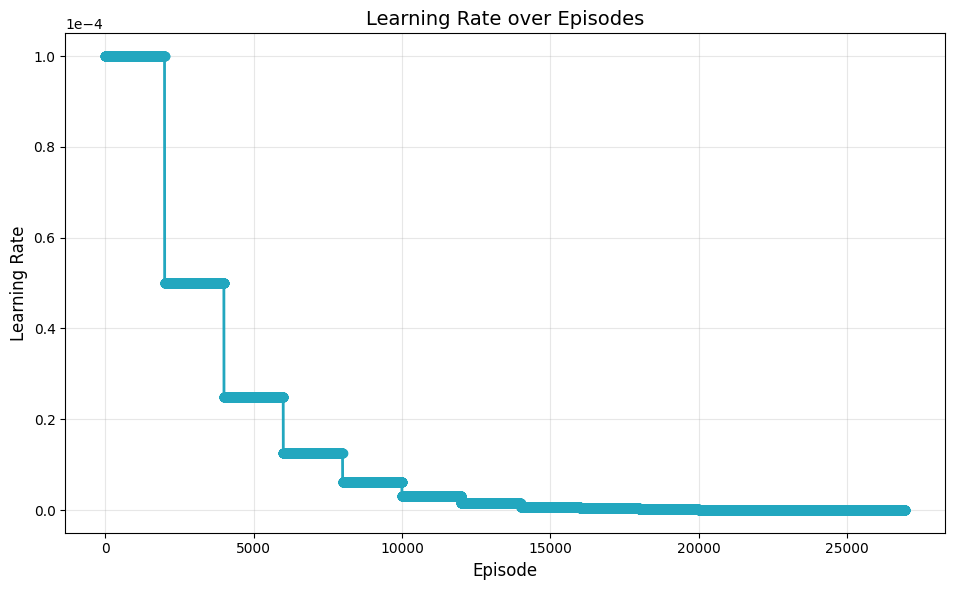

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('./exp/20250515/1/training_log.csv')  # Replace with your actual file path

# Create the learning rate plot
plt.figure(figsize=(10, 6))
plt.plot(df['episode'], df['lr'], marker='o', color='#22a7bf', linewidth=2)
plt.title('Learning Rate over Episodes', fontsize=14)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# If the learning rate values are very small scientific notation
# Consider using scientific notation format for y-axis
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# Save the plot if needed
# plt.savefig('learning_rate_plot.png', dpi=300)

plt.show()


Accuracy: 0.53946


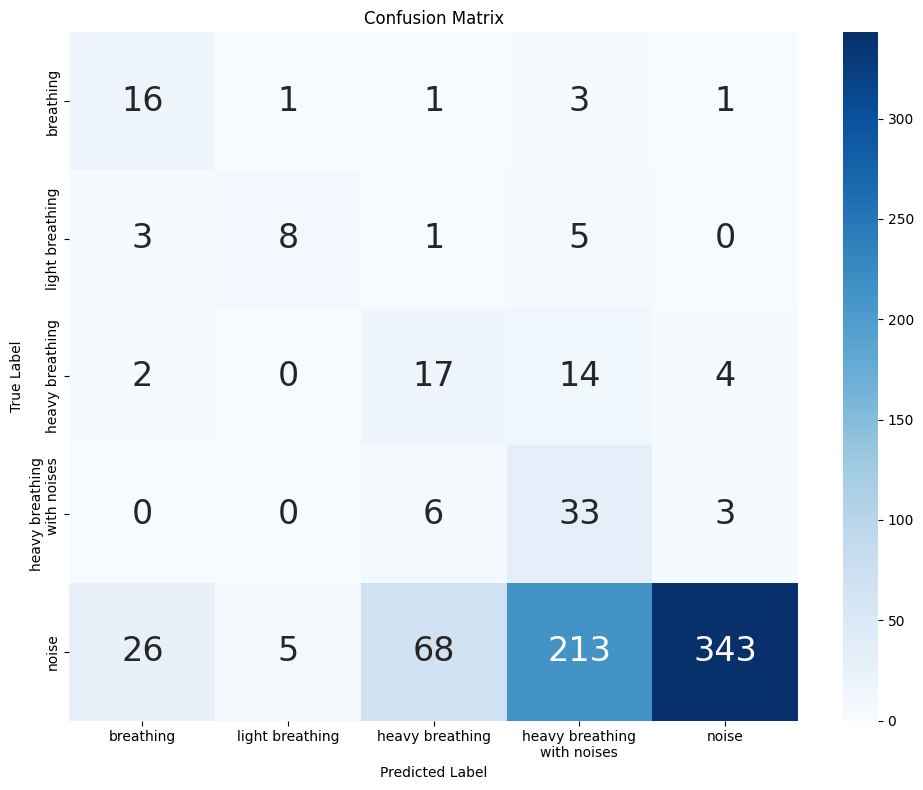

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(cm_path="test_confusion_matrix.csv", labels=None, title="Confusion Matrix", figsize=(10, 8), fontsize=16):
    """
    Plot a confusion matrix from a CSV file or a NumPy array.

    Args:
        cm_path (str or np.ndarray): Path to CSV file OR NumPy 2D array.
        labels (list): List of class labels for axes. Optional.
        title (str): Plot title.
    """
    # Load the matrix
    if isinstance(cm_path, str):
        cm = pd.read_csv(cm_path, skiprows=1, header=None, index_col=0).values
    else:
        cm = cm_path  # Assume it's already a NumPy array
    
    accuracy = np.trace(cm) / np.sum(cm)
    print(f"Accuracy: {accuracy:.5f}")

    # Create the plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="0,.0f", cmap="Blues", xticklabels=labels, yticklabels=labels, annot_kws={"size": fontsize})

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_confusion_matrix("./exp/20250605/3/full_prototype_confusion_matrix.csv",[], figsize=(15,14), fontsize=8)#, labels=["Non-Breathing", "Breathing"])
# plot_confusion_matrix("./exp/20250620/1/final_confusion_matrix.csv", labels=['breathing', 'light breathing', 'heavy breathing', 
#                 'heavy breathing\nwith noises', 'noise'], figsize=(10,8),fontsize=24)
plot_confusion_matrix("./exp/20250622/10/full_test_set_confusion_matrix.csv", labels=['breathing', 'light breathing', 'heavy breathing', 
                'heavy breathing\nwith noises', 'noise'], figsize=(10,8),fontsize=24)
# plot_confusion_matrix("./exp/20250608/3/full_prototype_confusion_matrix.csv", labels=['breathing', 'light breathing', 'heavy breathing', 
#                 'heavy breathing\nwith noises', 'noise'], figsize=(10,8),fontsize=24)

# plot_confusion_matrix("./exp/20250606/4/test_confusion_matrix_kmeans.csv", labels=[], figsize=(15,14),fontsize=6)
# plot_confusion_matrix("./exp/20250606/4/full_prototype_confusion_matrix.csv", labels=[], figsize=(15,14),fontsize=8)

/tmp/ipykernel_3080309/2926731445.py:100: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  eval_log = pd.read_csv(eval_log_path, skipfooter=1)


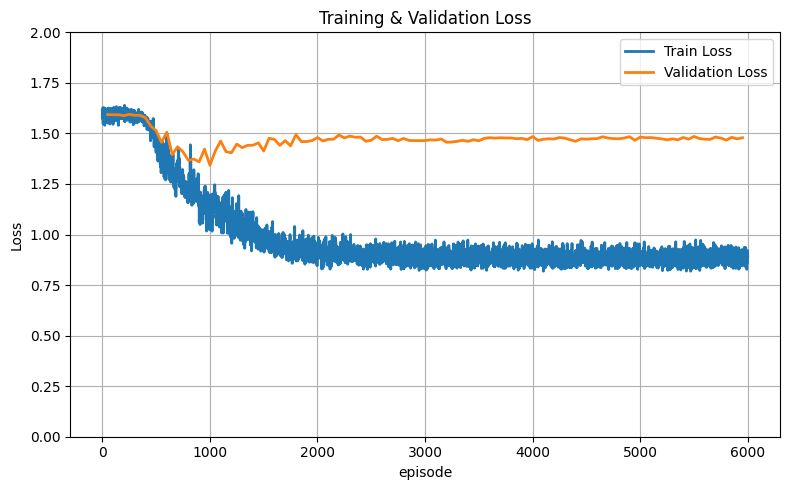

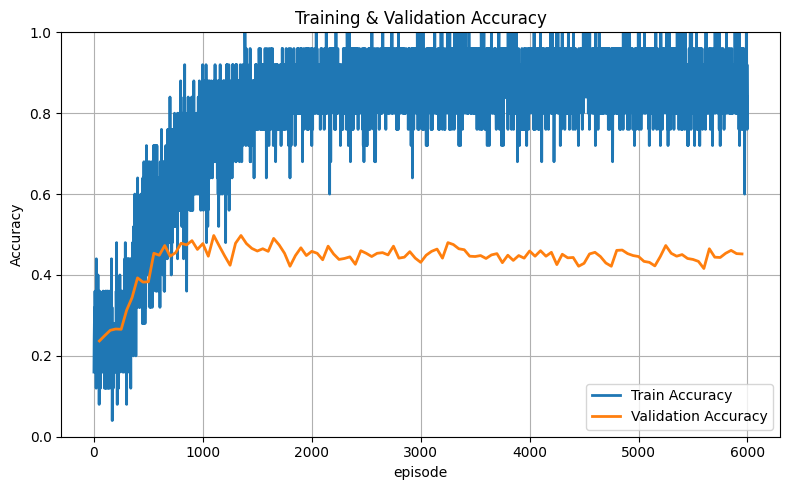

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_training_results(folder_path="."):
    """
    Plots training and validation loss and accuracy from CSV logs in the given folder.
    Y-axis is fixed to range [0, 1] for both plots.
    
    Args:
        folder_path (str): Path to the folder containing 'training_log.csv' and 'eval_log.csv'.
    """
    train_log_path = os.path.join(folder_path, "training_log.csv")
    eval_log_path = os.path.join(folder_path, "eval_log.csv")
    step = "episode"
    # Load logs
    train_log = pd.read_csv(train_log_path)
    eval_log = pd.read_csv(eval_log_path)

    # --- Plot Loss ---
    plt.figure(figsize=(8, 5))
    plt.plot(train_log[step], train_log["loss"], label="Train Loss", linewidth=2)
    plt.plot(eval_log[step], eval_log["loss"], label="Validation Loss", linewidth=2)
    plt.xlabel(step)
    plt.ylabel("Loss")
    plt.ylim(0, 2)
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot Accuracy ---
    plt.figure(figsize=(8, 5))
    plt.plot(train_log[step], train_log["accuracy"], label="Train Accuracy", linewidth=2)
    plt.plot(eval_log[step], eval_log["accuracy"], label="Validation Accuracy", linewidth=2)
    plt.xlabel(step)
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_qcnn_training_results(folder_path="."):
    """
    Plots training and validation loss and accuracy from CSV logs in the given folder.
    Y-axis is fixed to range [0, 1] for both plots.
    
    Args:
        folder_path (str): Path to the folder containing 'training_log.csv' and 'eval_log.csv'.
    """
    train_log_path = os.path.join(folder_path, "train_log.csv")
    eval_log_path = os.path.join(folder_path, "val_log.csv")
    step = "epoch"
    # Load logs
    train_log = pd.read_csv(train_log_path)
    eval_log = pd.read_csv(eval_log_path)

    # --- Plot Loss ---
    plt.figure(figsize=(8, 5))
    plt.plot(train_log[step], train_log["train_loss"], label="Train Loss", linewidth=2)
    plt.plot(eval_log[step], eval_log["val_loss"], label="Validation Loss", linewidth=2)
    plt.xlabel(step)
    plt.ylabel("Loss")
    plt.ylim(0, 2)
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot Accuracy ---
    plt.figure(figsize=(8, 5))
    plt.plot(train_log[step], train_log["train_acc"]/100, label="Train Accuracy", linewidth=2)
    plt.plot(eval_log[step], eval_log["val_acc"]/100, label="Validation Accuracy", linewidth=2)
    plt.xlabel(step)
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_attention_training_results(folder_path="."):
    """
    Plots training and validation loss and accuracy from CSV logs in the given folder.
    Y-axis is fixed to range [0, 1] for both plots.
    
    Args:
        folder_path (str): Path to the folder containing 'training_log.csv' and 'eval_log.csv'.
    """
    train_log_path = os.path.join(folder_path, "training_log.csv")
    eval_log_path = os.path.join(folder_path, "validation_log.csv")
    step = "episode"
    # Load logs
    train_log = pd.read_csv(train_log_path)
    eval_log = pd.read_csv(eval_log_path, skipfooter=1)

    # --- Plot Loss ---
    plt.figure(figsize=(8, 5))
    plt.plot(train_log[step], train_log["loss"], label="Train Loss", linewidth=2)
    plt.plot(eval_log[step], eval_log["loss"], label="Validation Loss", linewidth=2)
    plt.xlabel(step)
    plt.ylabel("Loss")
    plt.ylim(0, 2)
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot Accuracy ---
    plt.figure(figsize=(8, 5))
    plt.plot(train_log[step], train_log["accuracy"], label="Train Accuracy", linewidth=2)
    plt.plot(eval_log[step], eval_log["accuracy"], label="Validation Accuracy", linewidth=2)
    plt.xlabel(step)
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_cv_training_results(folder_path="."):
    """
    Plots training and validation loss and accuracy from CSV logs in the given folder.
    Y-axis is fixed to range [0, 1] for both plots.
    
    Args:
        folder_path (str): Path to the folder containing 'training_log.csv' and 'eval_log.csv'.
    """
    for i in range(1,6):
        train_log_path = os.path.join(folder_path, f"training_log_fold_{i}.csv")
        eval_log_path = os.path.join(folder_path, f"validation_log_fold_{i}.csv")
        step = "episode"
        # Load logs
        train_log = pd.read_csv(train_log_path)
        eval_log = pd.read_csv(eval_log_path)

        # --- Plot Loss ---
        plt.figure(figsize=(8, 5))
        plt.plot(train_log[step], train_log["loss"], label="Train Loss", linewidth=2)
        plt.plot(eval_log[step], eval_log["loss"], label="Validation Loss", linewidth=2)
        plt.xlabel(step)
        plt.ylabel("Loss")
        plt.ylim(0, 2)
        plt.title(f"Training & Validation Loss - Fold {i}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- Plot Accuracy ---
        plt.figure(figsize=(8, 5))
        plt.plot(train_log[step], train_log["accuracy"], label="Train Accuracy", linewidth=2)
        plt.plot(eval_log[step], eval_log["accuracy"], label="Validation Accuracy", linewidth=2)
        plt.xlabel(step)
        plt.ylabel("Accuracy")
        plt.ylim(0, 1)
        plt.title(f"Training & Validation Accuracy - Fold {i}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example usage:
# plot_training_results("exp/20250609/5") 
# plot_qcnn_training_results("exp/20250606/1")
plot_attention_training_results("./exp/20250702/4")
# plot_cv_training_results("./")  


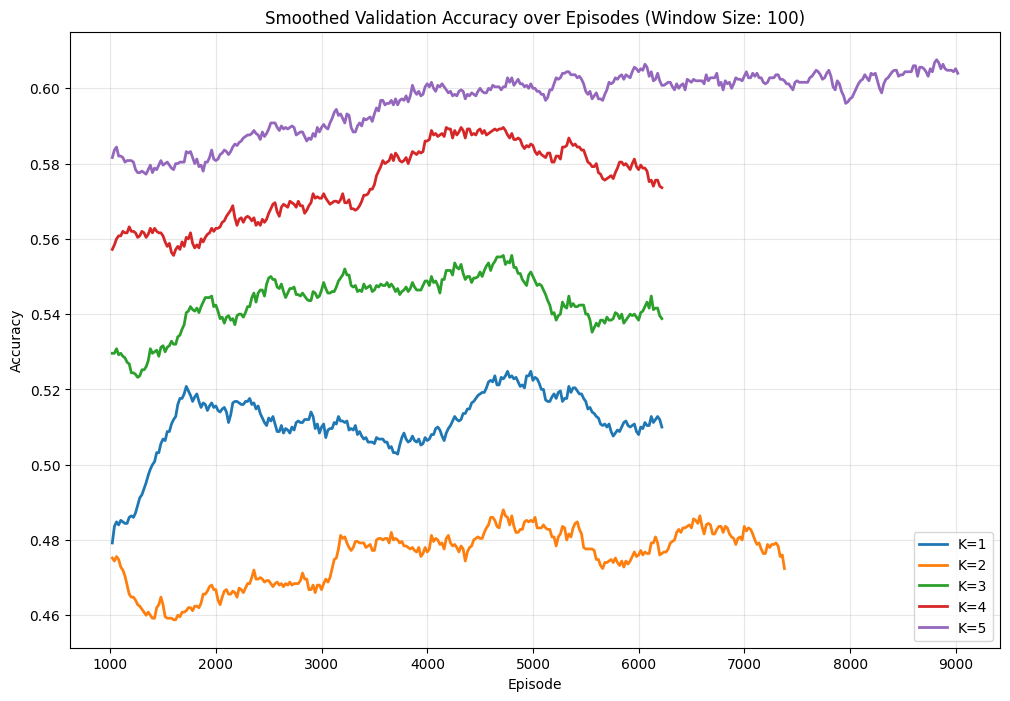

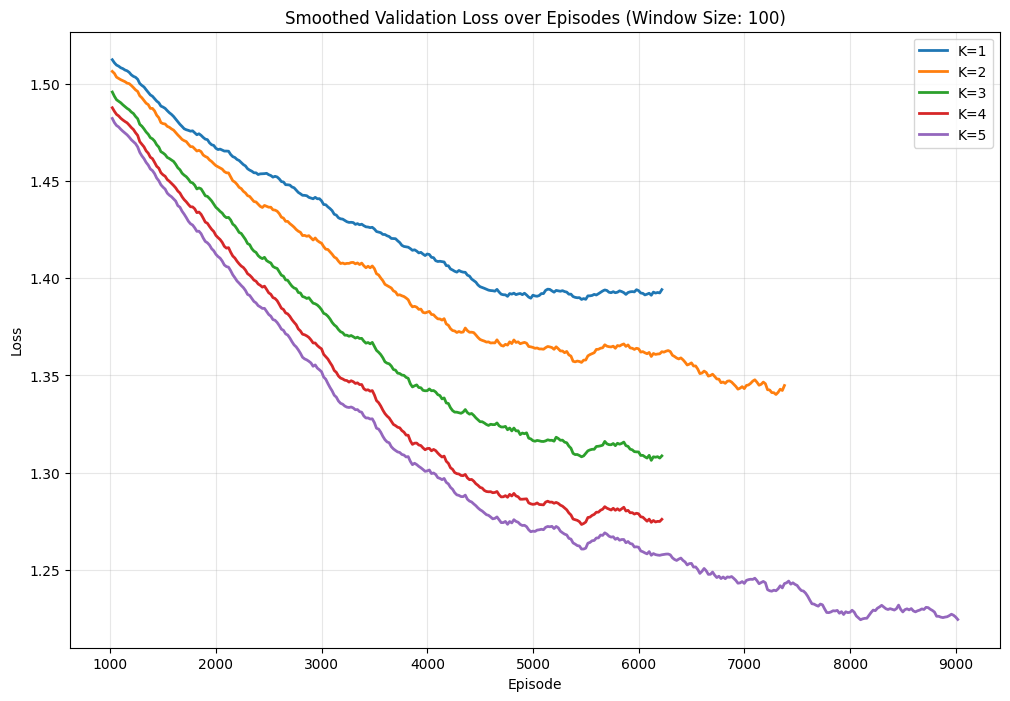

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the smoothing window size
window_size = 100  # Adjust this value to control smoothing level

# Create a figure with specified size for accuracy
plt.figure(figsize=(12, 8))

# Loop through folders 1 to 5 and read the training_log.csv files for accuracy
for i in range(1, 6):
    file_path = f'./exp/20250609/{i}/eval_log.csv'
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Apply moving average smoothing to the accuracy
    smoothed_accuracy = df['accuracy'].rolling(window=window_size, center=True).mean()
    
    # Plot smoothed accuracy vs episode for each training log
    plt.plot(df['episode'], smoothed_accuracy, label=f'K={i}', linewidth=2)

# Add labels and formatting for accuracy
plt.xlabel('Episode')
plt.ylabel('Accuracy')
plt.title(f'Smoothed Validation Accuracy over Episodes (Window Size: {window_size})')
plt.legend()
plt.grid(True, alpha=0.3)

# Show accuracy plot
plt.show()

# Create a figure with specified size for loss
plt.figure(figsize=(12, 8))

# Loop through folders 1 to 5 and read the training_log.csv files for loss
for i in range(1, 6):
    file_path = f'./exp/20250609/{i}/eval_log.csv'
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Apply moving average smoothing to the loss
    smoothed_loss = df['loss'].rolling(window=window_size, center=True).mean()
    
    # Plot smoothed loss vs episode for each training log
    plt.plot(df['episode'], smoothed_loss, label=f'K={i}', linewidth=2)

# Add labels and formatting for loss
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title(f'Smoothed Validation Loss over Episodes (Window Size: {window_size})')
plt.legend()
plt.grid(True, alpha=0.3)

# Show loss plot
plt.show()


In [ ]:
import os
import glob
from collections import defaultdict

def load_labels(label_path):
    labels = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split(maxsplit=2)
            if len(parts) == 3:
                onset, offset, label = parts
                labels.append((float(onset), float(offset), label.lower().strip()))
    return labels

def seconds_to_min_sec(seconds):
    minutes = int(seconds // 60)
    sec = int(seconds % 60)
    return f"{minutes}:{sec:02d}"

def count_label_durations(label_dir):
    label_durations = defaultdict(float)
    total_duration = 0.0

    label_files = glob.glob(os.path.join(label_dir, "*.txt"))
    
    for label_path in label_files:
        labels = load_labels(label_path)
        for onset, offset, label in labels:
            if "breathing" not in label :
               continue 
            duration = offset - onset
            label_durations[label] += duration
            total_duration += duration

    return label_durations, total_duration

# Example usage:
label_dir = "clean_label"  # change to your actual label folder
durations, total = count_label_durations(label_dir)

# Print results
print("\n📊 Duration by Label (mm:ss):")
for label, dur in sorted(durations.items(), key=lambda x: -x[1]):
    print(f"{label:20s}: {seconds_to_min_sec(dur)}")

print(f"\n🧮 Total labeled duration: {seconds_to_min_sec(total)} (mm:ss)")



📊 Duration by Label (mm:ss):
heavy breathing     : 15:43
clean heavy breathing: 12:39
breathing           : 4:58
clean breathing     : 1:26
light breathing     : 0:21
heavy breathing with noises: 0:04

🧮 Total labeled duration: 35:13 (mm:ss)


In [ ]:
import nemo.collections.asr as nemo_asr
asr_model = nemo_asr.models.ASRModel.from_pretrained(model_name="nvidia/parakeet-tdt-0.6b-v2")


/home/willy/miniconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[NeMo W 2025-05-11 22:31:25 nemo_logging:361] /home/willy/miniconda3/envs/ml/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    


In [ ]:
import os
import pandas as pd

label_folder = "clean label"

for label_file in os.listdir(label_folder):
    if label_file.endswith(".txt"):
        label_path = os.path.join(label_folder, label_file)
        labels = pd.read_csv(label_path, sep="\t", header=None)
        labels[2] = labels[2].str.lower().str.strip()
        print(labels[2].value_counts())
    else:
        print(f"Skipping {label_file}, not a .csv file.")


2
diaphragmatic      10
heavy breathing     3
breathing           1
Name: count, dtype: int64
2
heavy breathing    9
breathing          2
Name: count, dtype: int64
2
heavy breathing    9
Name: count, dtype: int64
2
breathing          2
clean breathing    1
Name: count, dtype: int64
2
heavy breathing                21
clean heavy breathing          16
breathing                       6
heavy breathing with noises     1
Name: count, dtype: int64
2
breathing    4
Name: count, dtype: int64
Skipping .DS_Store, not a .csv file.
2
heavy breathing    5
Name: count, dtype: int64
2
breathing    1
Name: count, dtype: int64
2
heavy breathing    9
breathing          7
clean breathing    3
light breathing    1
Name: count, dtype: int64
2
heavy breathing    15
breathing           9
clean breathing     3
Name: count, dtype: int64


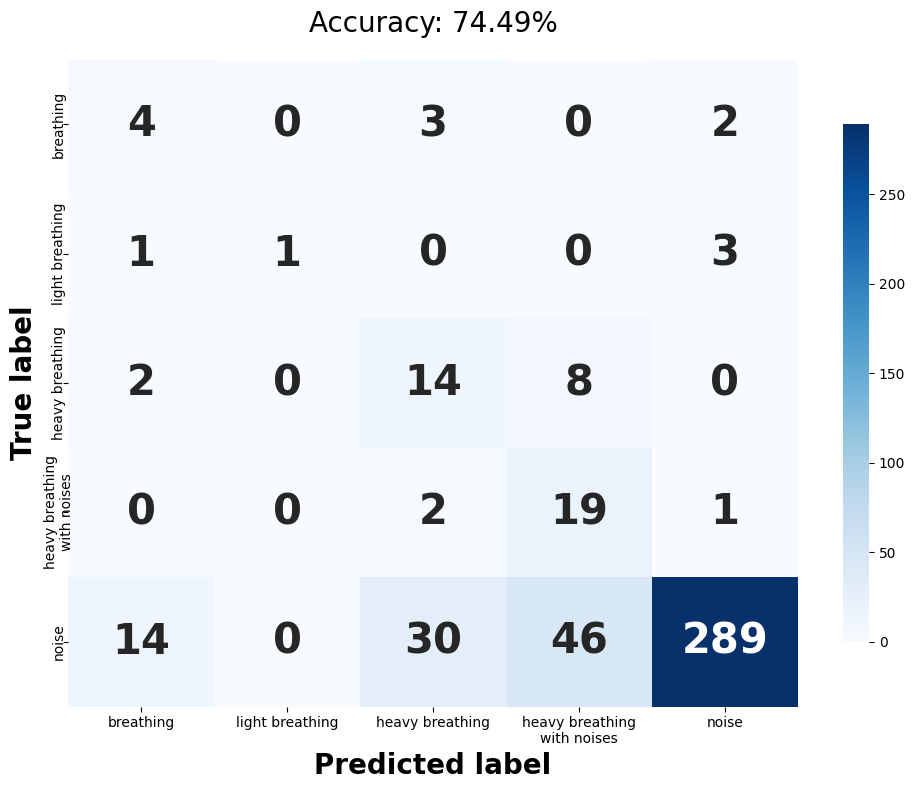

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your confusion matrix data from the image
cm = np.array([
    [9302, 396, 3755, 2847, 2689],
    [2136, 1555, 172, 3154, 3055],
    [14264, 328, 22014, 21437, 5375],
    [5117, 1586, 11580, 22088, 8196],
    [186910, 35673, 149938, 323590, 532592]
])

cm = np.array([
    [9302, 396, 3755, 2847],
    [2136, 1555, 172, 3154],
    [14264, 328, 22014, 21437],
    [5117, 1586, 11580, 22088]
])

cm = np.array([
    [11, 0, 4, 4],
    [2, 0, 0, 2],
    [6, 0, 15, 16],
    [0, 0, 7, 18]
])

cm = np.array([
    [13, 10],
    [6, 56]
])

cm = np.array([
    [8575, 416, 4807, 2170, 3021],
    [1857, 1535, 176, 4160, 2344],
    [8748, 288, 33628, 16178, 4576],
    [2245, 977, 19857, 18548, 6940],
    [95199, 32108, 144494, 207998, 748904]
])

cm = np.array([
    [8575, 416, 4807, 2170],
    [1857, 1535, 176, 4160],
    [8748, 288, 33628, 16178],
    [2245, 977, 19857, 18548]
])

cm = np.array([
    [11, 1, 5, 2],
    [1, 2, 0, 3],
    [6, 0, 24, 7],
    [1, 0, 15, 16]
])

cm = np.array([
    [15, 10],
    [7, 62]
])

cm = np.array([
    [9465, 1105, 6328, 2091],
    [3575, 1516, 384, 4597],
    [5152, 428, 44712, 13126],
    [3353, 1165, 28902, 15147]
])

cm = np.array([
    [12, 1, 6, 2],
    [4, 1, 0, 3],
    [6, 0, 30, 3],
    [4, 0, 20, 13]
])

cm = np.array([
    [6582, 1074, 5014, 5685, 634],
    [3612, 1125, 909, 4019, 407],
    [12118, 504, 5418, 40720, 4658],
    [15426, 2108, 3080, 17924, 10029],
    [483192, 101675, 155776, 168833, 319227]
])

cm = np.array([
    [6582, 1074, 5014, 5685],
    [3612, 1125, 909, 4019],
    [12118, 504, 5418, 40720],
    [15426, 2108, 3080, 17924]
])

cm = np.array([
    [10, 0, 4, 6],
    [4, 0, 1, 3],
    [12, 0, 2, 23],
    [8, 4, 1, 18]
])

cm = np.array([
    [14, 14],
    [24, 44]
])

cm = np.array([
    [7973, 270, 2141, 1526, 7079],
    [675, 34, 1337, 3902, 4124],
    [2698, 0, 20794, 19309, 20617],
    [2513, 144, 10934, 8809, 26167],
    [246534, 29085, 38118, 45498, 869468]
])

cm = np.array([
    [7973, 270, 2141, 1526],
    [675, 34, 1337, 3902],
    [2698, 0, 20794, 19309],
    [2513, 144, 10934, 8809]
])

cm = np.array([
    [7, 1, 4, 2],
    [1, 0, 1, 3],
    [3, 0, 11, 9],
    [3, 1, 8, 7]
])

cm = np.array([
    [9, 10],
    [7, 35]
])

cm = np.array([
 [  2,   0,   2,   0,   2],
 [  1,   3,   0,   1,   0],
 [  6,   1,   9,   4,   1],
 [  2,   1,   7,  10,   7],
 [ 37,  34,  51,  91, 290]
 ])

cm = np.array([
    [15, 1, 6, 3, 13],
    [2, 8, 0, 1, 9],
    [8, 0, 43, 37, 7],
    [0, 0, 5, 81, 0],
    [3, 0, 5, 12, 80]
])

cm = np.array([
    [4, 0, 3, 0, 2],
    [1, 1, 0, 0, 3],
    [2, 0, 14, 8, 0],
    [0, 0, 2, 19, 1],
    [14, 0, 30, 46, 289]
])


accuracy = np.trace(cm) / np.sum(cm) * 100

# Class labels
class_labels = ['breathing', 'light breathing', 'heavy breathing', 
                'heavy breathing\nwith noises', 'noise']

# class_labels = ['breathing', 'light breathing', 'heavy breathing', 
#                 'heavy breathing\nwith noises']

# class_labels = ['Normal', 'Abnormal']

# Create figure with appropriate size for the large matrix
plt.figure(figsize=(10, 8))

# Create heatmap with enlarged font for numbers
sns.heatmap(cm, 
            annot=True,                    # Show numbers
            fmt=',.0f',                    # Integer format
            cmap='Blues',                  # Blue color scheme like your image
            annot_kws={"size": 30, "weight": "bold"},  # Large bold font for numbers
            xticklabels=class_labels,      # X-axis labels
            yticklabels=class_labels,      # Y-axis labels
            cbar_kws={"shrink": 0.8})      # Adjust colorbar

# Customize labels and title with larger fonts
plt.xlabel('Predicted label', fontsize=20, fontweight='bold')
plt.ylabel('True label', fontsize=20, fontweight='bold')
plt.title(f'Accuracy: {accuracy:.2f}%', fontsize=20, pad=20)

# Make tick labels larger and rotate x-axis labels for better readability
plt.xticks(fontsize=10, rotation=0, ha='center')
plt.yticks(fontsize=10, rotation=90, ha='center')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()


In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def calculate_scores_from_confusion_matrix(conf_matrix: np.ndarray):
    """
    Calculates accuracy, macro F1, and weighted F1 scores from a confusion matrix.

    The function reconstructs the true and predicted labels from the matrix
    and then uses sklearn's functions to compute the scores.

    Args:
        conf_matrix (np.ndarray): A square NumPy array representing the confusion matrix.

    Returns:
        dict: A dictionary containing the calculated 'accuracy', 'macro_f1', and 'weighted_f1'.
    """
    # Reconstruct true and predicted labels from the confusion matrix
    y_true = []
    y_pred = []
    num_classes = conf_matrix.shape[0]

    for true_label in range(num_classes):
        for pred_label in range(num_classes):
            count = conf_matrix[true_label, pred_label]
            y_true.extend([true_label] * count)
            y_pred.extend([pred_label] * count)
    
    # Calculate scores using scikit-learn
    accuracy = accuracy_score(y_true, y_pred)
    # Use zero_division=0 to handle cases where a class has no predictions,
    # preventing warnings and correctly assigning a score of 0.
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
    }

# --- Main execution block ---
if __name__ == "__main__":
    # Define all confusion matrices from your slides
    all_confusion_matrices = {
        # --- GMM, Components=5 ---
        # "GMM_C5_Frame": np.array([
        #     [9302, 396, 3755, 2847, 2689],
        #     [2136, 1555, 172, 3154, 3055],
        #     [14264, 328, 22014, 21437, 5375],
        #     [5117, 1586, 11580, 22088, 8196],
        #     [186910, 35673, 149938, 323590, 532592]
        # ]),
        # "GMM_C5_Segment": np.array([
        #     [11, 0, 4, 4],
        #     [2, 0, 0, 2],
        #     [6, 0, 15, 16],
        #     [0, 0, 7, 18]
        # ]),
        # # --- GMM, Components=10 ---
        # "GMM_C10_Frame": np.array([
        #     [8575, 416, 4807, 2170, 3021],
        #     [1857, 1535, 176, 4160, 2344],
        #     [8748, 288, 33628, 16178, 4576],
        #     [2245, 977, 19857, 18548, 6940],
        #     [95199, 32108, 144494, 207998, 748904]
        # ]),
        # "GMM_C10_Segment": np.array([
        #     [11, 1, 5, 2],
        #     [1, 2, 0, 3],
        #     [6, 0, 24, 7],
        #     [1, 0, 15, 16]
        # ]),
        # # --- HMM, Components=5 ---
        # "HMM_C5_Frame": np.array([
        #     [6582, 1074, 5014, 5685, 634],
        #     [3612, 1125, 909, 4019, 407],
        #     [12118, 504, 5418, 40720, 4658],
        #     [15426, 2108, 3080, 17924, 10029],
        #     [483192, 101675, 155776, 168833, 319227]
        # ]),
        # "HMM_C5_Segment": np.array([
        #     [10, 0, 4, 6],
        #     [4, 0, 1, 3],
        #     [12, 0, 2, 23],
        #     [8, 4, 1, 18]
        # ]),
        # # --- XGBoost ---
        # "XGBoost_Frame": np.array([
        #     [7973, 270, 2141, 1526],
        #     [675, 34, 1337, 3902],
        #     [2698, 0, 20794, 19309],
        #     [2513, 144, 10934, 8809]
        # ]),
        # "XGBoost_Segment": np.array([
        #     [7, 1, 4, 2],
        #     [1, 0, 1, 3],
        #     [3, 0, 11, 9],
        #     [3, 1, 8, 7]
        # ]),

        # "CRNN_Train": np.array([
        #     [15, 1, 6, 3, 13],
        #     [2, 8, 0, 1, 9],
        #     [8, 0, 43, 37, 7],
        #     [0, 0, 5, 81, 0],
        #     [3, 0, 5, 12, 80]
        # ]),
        # "CRNN_Validation": np.array([
        #     [4, 0, 3, 0, 2],
        #     [1, 1, 0, 0, 3],
        #     [2, 0, 14, 8, 0],
        #     [0, 0, 2, 19, 1],
        #     [14, 0, 30, 46, 289]
        # ]),

        # "K=1_Matrix": np.array([
        #     [4, 3, 3, 0, 0],
        #     [1, 5, 0, 0, 0],
        #     [10, 0, 19, 7, 3],
        #     [9, 0, 7, 9, 13],
        #     [64, 57, 41, 138, 356]
        # ]),
        # "K=2_Matrix": np.array([
        #     [8, 1, 0, 1, 0],
        #     [0, 5, 1, 0, 0],
        #     [8, 1, 22, 3, 5],
        #     [4, 3, 10, 16, 5],
        #     [55, 67, 67, 93, 374]
        # ]),
        # "K=3_Matrix": np.array([
        #     [4, 2, 2, 1, 1],
        #     [0, 5, 1, 0, 0],
        #     [12, 1, 12, 9, 5],
        #     [6, 1, 10, 15, 6],
        #     [98, 33, 82, 102, 341]
        # ]),
        # "K=4_Matrix": np.array([
        #     [4, 1, 4, 0, 1],
        #     [0, 5, 0, 0, 1],
        #     [10, 0, 18, 5, 6],
        #     [3, 3, 11, 15, 6],
        #     [53, 30, 96, 102, 375]
        # ]),
        # "K=5_Matrix": np.array([
        #     [6, 0, 3, 0, 1],
        #     [0, 5, 1, 0, 0],
        #     [9, 0, 14, 10, 6],
        #     [3, 3, 5, 15, 12],
        #     [75, 39, 50, 126, 366]
        # ]),

        # "E1_K=1_Matrix": np.array([
        #     [20, 0, 0, 2, 5],
        #     [0, 14, 0, 3, 1],
        #     [2, 0, 26, 3, 5],
        #     [1, 0, 5, 22, 0],
        #     [13, 24, 85, 177, 365]
        # ]),
        # "E1_K=2_Matrix": np.array([
        #     [25, 1, 0, 1, 0],
        #     [0, 16, 0, 0, 2],
        #     [6, 0, 21, 7, 2],
        #     [1, 2, 1, 18, 6],
        #     [271, 50, 81, 157, 105]
        # ]),
        # "E1_K=3_Matrix": np.array([
        #     [22, 1, 3, 1, 0],
        #     [1, 16, 0, 1, 0],
        #     [6, 1, 27, 2, 0],
        #     [1, 0, 12, 15, 0],
        #     [229, 18, 140, 273, 4]
        # ]),
        # "E1_K=4_Matrix": np.array([
        #     [20, 1, 2, 3, 1],
        #     [1, 16, 0, 0, 1],
        #     [2, 1, 32, 1, 0],
        #     [0, 1, 12, 15, 0],
        #     [15, 22, 358, 233, 36]
        # ]),
        # "E1_K=5_Matrix": np.array([
        #     [19, 3, 2, 2, 1],
        #     [0, 15, 0, 1, 2],
        #     [4, 1, 25, 6, 0],
        #     [0, 0, 4, 23, 1],
        #     [186, 63, 86, 226, 103]
        # ]),

        # "E2_K=1_Matrix": np.array([
        #     [4, 1, 4, 1, 3],
        #     [0, 0, 1, 0, 1],
        #     [0, 0, 32, 1, 0],
        #     [0, 0, 28, 6, 3],
        #     [52, 14, 154, 36, 409]
        # ]),
        # "E2_K=2_Matrix": np.array([
        #     [0, 2, 5, 3, 3],
        #     [0, 0, 1, 0, 1],
        #     [0, 0, 32, 0, 1],
        #     [0, 1, 29, 4, 3],
        #     [2, 14, 175, 31, 443]
        # ]),
        # "E2_K=3_Matrix": np.array([
        #     [5, 2, 0, 3, 3],
        #     [0, 0, 0, 1, 1],
        #     [1, 1, 2, 26, 3],
        #     [3, 6, 2, 18, 8],
        #     [55, 41, 6, 115, 448]
        # ]),
        # "E2_K=4_Matrix": np.array([
        #     [1, 5, 0, 4, 3],
        #     [0, 0, 0, 1, 1],
        #     [0, 0, 2, 27, 4],
        #     [5, 0, 2, 21, 9],
        #     [49, 24, 6, 126, 460]
        # ]),
        # "E2_K=5_Matrix": np.array([
        #     [0, 5, 1, 4, 3],
        #     [0, 1, 0, 1, 0],
        #     [0, 0, 2, 28, 3],
        #     [0, 3, 2, 25, 7],
        #     [6, 44, 42, 142, 431]
        # ]),

        # "E3_K=1_Matrix": np.array([
        #     [11, 5, 3, 1, 2],
        #     [3, 10, 2, 1, 1],
        #     [10, 1, 16, 3, 7],
        #     [8, 5, 11, 10, 8],
        #     [97, 38, 59, 111, 350]
        # ]),
        # "E3_K=2_Matrix": np.array([
        #     [15, 5, 0, 1, 1],
        #     [5, 9, 2, 1, 0],
        #     [21, 4, 6, 2, 4],
        #     [12, 17, 0, 8, 5],
        #     [106, 159, 13, 82, 295]
        # ]),
        # "E3_K=3_Matrix": np.array([
        #     [12, 6, 1, 2, 1],
        #     [3, 10, 2, 1, 1],
        #     [12, 8, 7, 6, 4],
        #     [6, 22, 0, 9, 5],
        #     [55, 193, 22, 121, 264]
        # ]),
        # "E3_K=4_Matrix": np.array([
        #     [14, 4, 2, 1, 1],
        #     [6, 8, 3, 0, 0],
        #     [10, 4, 5, 11, 7],
        #     [7, 11, 1, 18, 5],
        #     [103, 98, 19, 125, 310]
        # ]),
        # "E3_K=5_Matrix": np.array([
        #     [10, 7, 3, 2, 0],
        #     [3, 10, 3, 1, 0],
        #     [11, 0, 18, 1, 7],
        #     [10, 4, 11, 12, 5],
        #     [119, 21, 65, 133, 317]
        # ])

        "E4_K=1_Matrix": np.array([ [14, 1, 0, 7, 0], [2, 8, 3, 4, 0], [7, 0, 13, 12, 5], [3, 0, 6, 28, 5], [42, 6, 62, 257, 288] ]),
        "E4_K=2_Matrix": np.array([ [15, 4, 3, 0, 0], [4, 11, 1, 1, 0], [2, 0, 20, 12, 3], [2, 0, 11, 26, 3], [41, 3, 86, 157, 368] ]),
        "E4_K=3_Matrix": np.array([ [11, 3, 4, 1, 3], [3, 12, 1, 0, 1], [2, 0, 16, 16, 3], [1, 0, 6, 22, 13], [30, 3, 60, 131, 431] ]),
        "E4_K=4_Matrix": np.array([ [12, 5, 3, 1, 1], [3, 12, 0, 1, 1], [2, 0, 18, 14, 3], [1, 0, 9, 25, 7], [33, 4, 54, 169, 395] ]),
        "E4_K=5_Matrix": np.array([ [16, 1, 1, 3, 1], [3, 8, 1, 5, 0], [2, 0, 17, 14, 4], [0, 0, 6, 33, 3], [26, 5, 68, 213, 343] ])

        
    }

    # Calculate and print scores for each matrix
    print("-" * 60)
    print("Verification of Performance Metrics from Confusion Matrices")
    print("-" * 60)
    
    for name, matrix in all_confusion_matrices.items():
        scores = calculate_scores_from_confusion_matrix(matrix)
        print(f"\nResults for: {name}")
        print(f"  -> Accuracy:      {scores['accuracy']:.4f}")
        print(f"  -> Macro F1:      {scores['macro_f1']:.4f}")
        print(f"  -> Weighted F1:   {scores['weighted_f1']:.4f}")
    
    print("-" * 60)



------------------------------------------------------------
Verification of Performance Metrics from Confusion Matrices
------------------------------------------------------------

Results for: E4_K=1_Matrix
  -> Accuracy:      0.4541
  -> Macro F1:      0.3581
  -> Weighted F1:   0.5510

Results for: E4_K=2_Matrix
  -> Accuracy:      0.5692
  -> Macro F1:      0.4329
  -> Weighted F1:   0.6538

Results for: E4_K=3_Matrix
  -> Accuracy:      0.6365
  -> Macro F1:      0.4499
  -> Weighted F1:   0.7082

Results for: E4_K=4_Matrix
  -> Accuracy:      0.5977
  -> Macro F1:      0.4400
  -> Weighted F1:   0.6786

Results for: E4_K=5_Matrix
  -> Accuracy:      0.5395
  -> Macro F1:      0.4272
  -> Weighted F1:   0.6265
------------------------------------------------------------


In [1]:
import numpy as np
import re

def parse_classification_report(report_text):
    """
    Parse classification report text into a matrix and calculate macro F1
    """
    lines = report_text.strip().split('\n')
    
    # Find class lines (skip header and summary lines)
    class_data = []
    class_names = []
    
    for line in lines[2:]:  # Skip header lines
        line = line.strip()
        if line and not line.startswith('accuracy') and not line.startswith('macro avg') and not line.startswith('weighted avg'):
            # Split the line and extract metrics
            parts = line.split()
            if len(parts) >= 4:  # Ensure we have all required columns
                class_name = ' '.join(parts[:-4])  # Class name (can be multiple words)
                precision = float(parts[-4])
                recall = float(parts[-3])
                f1_score = float(parts[-2])
                support = int(parts[-1])
                
                class_names.append(class_name)
                class_data.append([precision, recall, f1_score, support])
    
    # Convert to numpy matrix
    metrics_matrix = np.array(class_data)
    
    return class_names, metrics_matrix

def calculate_macro_f1(metrics_matrix):
    """
    Calculate macro F1 score from the metrics matrix
    F1 scores are in column index 2
    """
    f1_scores = metrics_matrix[:, 2]  # Extract F1 column
    macro_f1 = np.mean(f1_scores)    # Calculate mean
    return macro_f1

# Your classification report
report_text = '''                             precision    recall  f1-score   support

                  breathing       0.08      0.50      0.14        12
            light breathing       0.00      0.00      0.00         5
            heavy breathing       0.26      0.68      0.38        34
heavy breathing with noises       0.19      0.61      0.29        41
               no breathing       0.97      0.66      0.79       657

                   accuracy                           0.65       749
                  macro avg       0.30      0.49      0.32       749
               weighted avg       0.88      0.65      0.73       749'''

# Parse the report
class_names, metrics_matrix = parse_classification_report(report_text)

print("Class Names:")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")

print("\nMetrics Matrix:")
print("Columns: [Precision, Recall, F1-Score, Support]")
print(metrics_matrix)

print(f"\nMatrix shape: {metrics_matrix.shape}")

# Calculate macro F1
macro_f1 = calculate_macro_f1(metrics_matrix)
print(f"\nCalculated Macro F1: {macro_f1:.4f}")

# Extract individual F1 scores for verification
f1_scores = metrics_matrix[:, 2]
print(f"\nIndividual F1 scores: {f1_scores}")
print(f"Manual calculation: {np.sum(f1_scores)} / {len(f1_scores)} = {np.sum(f1_scores) / len(f1_scores):.4f}")


Class Names:
0: breathing
1: light breathing
2: heavy breathing
3: heavy breathing with noises
4: no breathing

Metrics Matrix:
Columns: [Precision, Recall, F1-Score, Support]
[[8.00e-02 5.00e-01 1.40e-01 1.20e+01]
 [0.00e+00 0.00e+00 0.00e+00 5.00e+00]
 [2.60e-01 6.80e-01 3.80e-01 3.40e+01]
 [1.90e-01 6.10e-01 2.90e-01 4.10e+01]
 [9.70e-01 6.60e-01 7.90e-01 6.57e+02]]

Matrix shape: (5, 4)

Calculated Macro F1: 0.3200

Individual F1 scores: [0.14 0.   0.38 0.29 0.79]
Manual calculation: 1.6 / 5 = 0.3200


In [15]:
import pandas as pd
from sklearn.metrics import classification_report
from io import StringIO

def generate_classification_report_from_csv(csv_file_path):
    """
    Generate a classification report from a CSV file containing a confusion matrix.
    The report will be printed in the order of labels as they appear in the CSV.
    
    Args:
        csv_file_path (str): Path to the CSV file
    """
    # Read the CSV file
    conf_matrix = pd.read_csv(csv_file_path, index_col=0)
    
    # Extract true labels and predicted labels in their original order
    true_labels = conf_matrix.index.tolist()
    pred_labels = conf_matrix.columns.tolist()
    
    # Convert confusion matrix to lists of true and predicted labels
    true = []
    pred = []
    
    for true_label in true_labels:
        for pred_label in pred_labels:
            count = conf_matrix.loc[true_label, pred_label]
            true.extend([true_label] * count)
            pred.extend([pred_label] * count)
    
    # Generate classification report with labels in original order
    report = classification_report(true, pred, labels=true_labels, digits=4)
    print(report)
    
    return report


# Example usage with your data
if __name__ == "__main__":
    # If you have the data in a CSV file, use:
    generate_classification_report_from_csv('./exp/20250702/5/full_test_set_confusion_matrix.csv')


                             precision    recall  f1-score   support

                  breathing     0.1562    0.2273    0.1852        22
            light breathing     0.2909    0.9412    0.4444        17
            heavy breathing     0.0704    0.7568    0.1287        37
heavy breathing with noises     0.0800    0.4286    0.1348        42
               no breathing     0.9206    0.0885    0.1616       655

                   accuracy                         0.1617       773
                  macro avg     0.3036    0.4885    0.2110       773
               weighted avg     0.7987    0.1617    0.1654       773



Generating audio waveform...


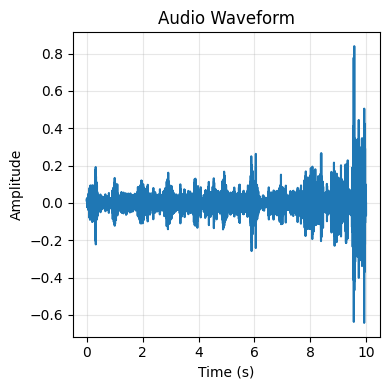

Generating log Mel spectrogram...


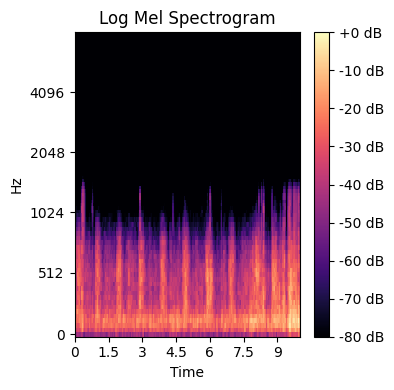

Extracting Whisper-tiny encoder embeddings...
Embedding shape: (1500, 384)
Plotting embeddings...


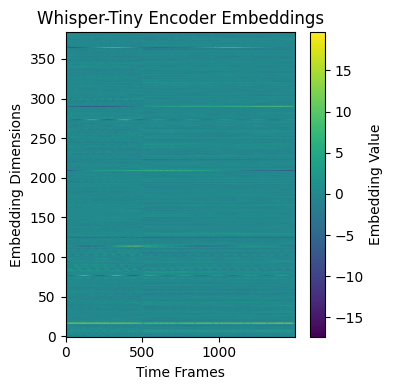

In [7]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# def plot_log_mel_spectrogram(audio_path, duration=10, sr=22050, n_mels=128, fmax=8000):
#     # Load only the first 'duration' seconds of the audio file
#     y, sr = librosa.load(audio_path, sr=sr, duration=duration)
    
#     # Generate Mel spectrogram
#     S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    
#     # Convert to log scale (dB)
#     log_S = librosa.power_to_db(S, ref=np.max)
    
#     # Plot the log Mel spectrogram
#     plt.figure(figsize=(5, 4))
#     librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', fmax=fmax)
#     plt.colorbar(format='%+2.0f dB')
#     plt.title('Log Mel Spectrogram')
#     plt.tight_layout()
#     plt.show()

# Example usage
# plot_log_mel_spectrogram('./pig_sed/segmented_audio/20250109_338_segment_700.wav')

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import WhisperProcessor, WhisperModel

def plot_log_mel_spectrogram(audio_path, duration=10, sr=16000, n_mels=80, fmax=8000):
    """Plot log Mel spectrogram from audio file"""
    # Load only the first 'duration' seconds of the audio file
    y, sr = librosa.load(audio_path, sr=sr, duration=duration)
    
    # Generate Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Convert to log scale (dB)
    log_S = librosa.power_to_db(S, ref=np.max)
    
    # Plot the log Mel spectrogram
    plt.figure(figsize=(4, 4))
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', fmax=fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log Mel Spectrogram')
    plt.tight_layout()
    plt.show()

def plot_waveform(audio_path, duration=10, sr=16000):
    """Plot audio waveform"""
    # Load audio
    y, sr = librosa.load(audio_path, sr=sr, duration=duration)
    
    # Create time axis
    time = np.linspace(0, len(y) / sr, len(y))
    
    # Plot waveform
    plt.figure(figsize=(4, 4))
    plt.plot(time, y)
    plt.title('Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def get_whisper_encoder_embedding(audio_path, model_name='openai/whisper-tiny', duration=10):
    """Extract encoder embeddings from Whisper-tiny model"""
    # Load audio at 16kHz (Whisper's expected sampling rate)
    y, sr = librosa.load(audio_path, sr=16000, duration=duration)
    
    # Load processor and model
    processor = WhisperProcessor.from_pretrained(model_name)
    model = WhisperModel.from_pretrained(model_name)
    
    # Prepare input features
    inputs = processor(y, sampling_rate=sr, return_tensors="pt")
    
    # Get encoder outputs
    with torch.no_grad():
        encoder_outputs = model.encoder(inputs.input_features)
    
    # Extract embeddings
    embeddings = encoder_outputs.last_hidden_state
    return embeddings.squeeze(0).cpu().numpy()

def plot_embeddings(embeddings):
    """Plot Whisper encoder embeddings as a heatmap"""
    plt.figure(figsize=(4, 4))
    plt.imshow(embeddings.T, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Embedding Value')
    plt.title('Whisper-Tiny Encoder Embeddings')
    plt.xlabel('Time Frames')
    plt.ylabel('Embedding Dimensions')
    plt.tight_layout()
    plt.show()

def analyze_audio_complete(audio_path, duration=10):
    """Complete audio analysis with all three visualizations"""
    print("Generating audio waveform...")
    plot_waveform(audio_path, duration)
    
    print("Generating log Mel spectrogram...")
    plot_log_mel_spectrogram(audio_path, duration)
    
    print("Extracting Whisper-tiny encoder embeddings...")
    embeddings = get_whisper_encoder_embedding(audio_path, duration=duration)
    
    print(f"Embedding shape: {embeddings.shape}")
    print("Plotting embeddings...")
    plot_embeddings(embeddings)
    
    return embeddings

# Example usage
if __name__ == "__main__":
    # Replace with your audio file path
    audio_file = './pig_sed/segmented_audio/20250109_338_segment_700.wav'
    
    # Generate all three plots
    embeddings = analyze_audio_complete(audio_file, duration=10)

